<a href="https://colab.research.google.com/github/Kim-matthew-0422/GAN_progan/blob/main/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/CelebAMask-HQ.zip'

Streaming output truncated to the last 5000 lines.
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_nose.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_r_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_skin.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19597_u_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_hair.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_brow.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_eye.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_l_lip.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_mouth.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_neck.png  
  inflating: CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/19598_nose.png  
  inflating: CelebAMask-HQ/Cel

In [ ]:
import gdown
from zipfile import ZipFile


url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

FileNotFoundError: ignored

In [ ]:
!ls celeba_gan/img_align_celeba

Streaming output truncated to the last 5000 lines.
028768.jpg  062535.jpg	096302.jpg  130069.jpg	163836.jpg  197603.jpg
028769.jpg  062536.jpg	096303.jpg  130070.jpg	163837.jpg  197604.jpg
028770.jpg  062537.jpg	096304.jpg  130071.jpg	163838.jpg  197605.jpg
028771.jpg  062538.jpg	096305.jpg  130072.jpg	163839.jpg  197606.jpg
028772.jpg  062539.jpg	096306.jpg  130073.jpg	163840.jpg  197607.jpg
028773.jpg  062540.jpg	096307.jpg  130074.jpg	163841.jpg  197608.jpg
028774.jpg  062541.jpg	096308.jpg  130075.jpg	163842.jpg  197609.jpg
028775.jpg  062542.jpg	096309.jpg  130076.jpg	163843.jpg  197610.jpg
028776.jpg  062543.jpg	096310.jpg  130077.jpg	163844.jpg  197611.jpg
028777.jpg  062544.jpg	096311.jpg  130078.jpg	163845.jpg  197612.jpg
028778.jpg  062545.jpg	096312.jpg  130079.jpg	163846.jpg  197613.jpg
028779.jpg  062546.jpg	096313.jpg  130080.jpg	163847.jpg  197614.jpg
028780.jpg  062547.jpg	096314.jpg  130081.jpg	163848.jpg  197615.jpg
028781.jpg  062548.jpg	096315.jpg  130082.jpg	163849

In [ ]:
import os
import cv2
import numpy as np

def load_celeba_data(batch_size, img_size, data_path='./celeba_gan/img_align_celeba', num_samples=None):
    image_paths = sorted([os.path.join(data_path, img) for img in os.listdir(data_path)])

    if num_samples:
        image_paths = image_paths[:num_samples]

    def preprocess_image(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = (img - 127.5) / 127.5
        return img

    def image_generator():
        for img_path in image_paths:
            yield preprocess_image(img_path)

    dataset = tf.data.Dataset.from_generator(image_generator, output_signature=tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
@tf.function
def wasserstein_discriminator_loss(real_output: tf.Tensor, fake_output: tf.Tensor) -> tf.Tensor:

    return fake_output - real_output


@tf.function
def wasserstein_generator_loss(fake_output: tf.Tensor) -> tf.Tensor:

    return -fake_output


def wasserstein_gradient_penalty(discriminator: tf.keras.Model, real_images: tf.Tensor, fake_images: tf.Tensor,
                                 wgan_target: float, wgan_lambda: float, *args) -> tf.Tensor:
    # create mixed images
    local_batch_size = tf.shape(real_images)[0]
    mixing_factors = tf.random.uniform([local_batch_size, 1, 1, 1], 0.0, 1.0)
    mixed_images = real_images + (fake_images - real_images) * mixing_factors

    # apply forward pass, compute mixed norm and penalty
    with tf.GradientTape(watch_accessed_variables=False) as mixed_tape:
        mixed_tape.watch(mixed_images)
        mixed_output = discriminator([mixed_images, *args], training=True)
    gradient_mixed = mixed_tape.gradient(mixed_output, mixed_images)
    gradient_mixed_norm = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(gradient_mixed), axis=[1, 2, 3]))
    gradient_penalty = tf.square(gradient_mixed_norm - wgan_target)
    return gradient_penalty * (wgan_lambda / (wgan_target ** 2))


@tf.function
def discriminator_epsilon_drift(real_output: tf.Tensor, wgan_epsilon: float) -> tf.Tensor:

    return tf.square(real_output) * wgan_epsilon


In [ ]:
import os
import warnings
from typing import Union, Tuple, Optional

import tensorflow as tf
import numpy as np
from PIL import Image


def get_environment_variable(identifier: str) -> str:

    if not isinstance(identifier, str):
        raise TypeError(f"identifier must be of type str but found type(identifier)={type(identifier)} instead.")
    if identifier == "":
        raise ValueError(f"identifier must be non-empty string, yet received empty string.")
    env_variable = os.environ.get(identifier)
    if env_variable is None:
        raise EnvironmentError(f"environment variable ${identifier} is not set")
    return env_variable


def create_directory(directory: Union[str, bytes, os.PathLike], *args, **kwargs) -> None:

    if not isinstance(directory, (str, bytes, os.PathLike)):
        raise TypeError(f"directory must be str, bytes or os.PathLike, but found {type(directory)} instead")
    if os.path.exists(directory):
        if os.path.isfile(directory) or os.path.islink(directory):
            raise FileExistsError(f"{directory} already exists as a file/link and can't be created")
    else:
        os.makedirs(directory, *args, **kwargs)


def save_eval_images(
        static_noise: tf.Tensor,
        generator: tf.keras.Model,
        epoch: int,
        output_dir: Union[str, bytes, os.PathLike],
        alpha: tf.Tensor,
        stage: int = 0,
        data_format: str = "channels_last") -> None:

    if data_format not in ['NCHW', 'NHWC', 'channels_first', 'channels_last']:
        raise ValueError(f'undefined data_format={data_format}')
    noise_shape = tf.shape(static_noise)
    channel_axis = -1 if data_format == 'NHWC' or data_format == 'channels_last' else 1

    # inference on generator to get images
    if len(generator.outputs) == 1:  # generator only has output for current stage
        fixed_predictions = generator([static_noise, alpha], training=False).numpy()
        rand_predictions = generator([np.random.normal(size=noise_shape), alpha], training=False).numpy()
    else:  # generator has output for all stages
        if not 2 <= stage <= 10:
            raise IndexError(f"generator has output for stages 2 to {2+len(generator.outputs)}: "
                             f"attempted to access output for stage {stage}")
        fixed_predictions = generator([static_noise, alpha], training=False)[stage - 2].numpy()
        rand_predictions = generator([np.random.normal(size=noise_shape), alpha], training=False)[stage - 2].numpy()

    # from tf.float32 [-1, 1] to np.uint8 [0, 255]
    fixed_predictions = 255 * ((fixed_predictions + 1.0) / 2.0)
    rand_predictions = 255 * ((rand_predictions + 1.0) / 2.0)
    fixed_predictions.astype(dtype=np.uint8, copy=False)
    rand_predictions.astype(dtype=np.uint8, copy=False)

    # get output dims, swap axes in case of channels_first
    if channel_axis == -1:
        num_images, height, width, channels = fixed_predictions.shape
    else:
        num_images, channels, height, width = fixed_predictions.shape
        fixed_predictions = np.einsum('nchw->nhwc', fixed_predictions)
        rand_predictions = np.einsum('nchw->nhwc', rand_predictions)

    # output container for image, first column are fixed_random_seed pictures, second are not seeded-random
    predictions = np.empty(shape=[2 * height, num_images * width,  channels], dtype=np.uint8)
    for index in range(len(fixed_predictions)):
        predictions[:height, index * width:(index + 1) * width, :] = fixed_predictions[index]
        predictions[height:, index * width:(index + 1) * width, :] = rand_predictions[index]
    image = Image.fromarray(predictions)
    name = f"{generator.name}_epoch-{epoch+1:04d}_alpha-{alpha.numpy():.3f}_shape-{width}x{height}x{channels}.png"
    image.save(os.path.join(output_dir, name))

    # clean up
    image.close()
    del fixed_predictions
    del rand_predictions
    del predictions


def transfer_ema_weights(
        source_model: tf.keras.Model,
        target_model: tf.keras.Model,
        source_ema: Optional[tf.train.ExponentialMovingAverage] = None,
        layer_name_prefix: str = '') -> None:

    for source_layer in source_model.layers:
        source_vars = source_layer.variables
        if source_layer.name.startswith(layer_name_prefix) and source_vars:
            try:
                target_layer = target_model.get_layer(name=source_layer.name)
            except ValueError:
                continue
            for source_var, target_var in zip(source_vars, target_layer.variables):
                if source_ema is not None:
                    transfer_var = source_ema.average(source_var)
                else:
                    transfer_var = source_var
                target_var.assign(transfer_var)


def he_initializer_scale(kernel_shape, gain: float = 2.0):

    fan_in = np.prod(kernel_shape[:-1])
    return np.sqrt(gain / fan_in)

def he_kernel_initializer(kernel_shape, gain: float = 2.0, use_weight_scaling: bool = True) \
        -> Tuple[float, tf.initializers.Initializer]:
    warnings.warn("he_kernel_initializer is deprecated. Use he_initializer_scale instead.", DeprecationWarning, 2)
    he_scale = he_initializer_scale(kernel_shape=kernel_shape, gain=gain)
    if use_weight_scaling:
        op_scale = he_scale
        kernel_initializer = tf.keras.initializers.RandomNormal()
    else:
        op_scale = 1.0
        kernel_initializer = tf.keras.initializers.RandomNormal(0, he_scale)
    return op_scale, kernel_initializer


def transfer_weights(
        source_model: tf.keras.Model,
        target_model: tf.keras.Model,
        is_cloned: bool = False,
        layer_name_prefix: str = '',
        beta: float = 0.0) -> None:

    if not 0.0 <= beta < 1.0:
        raise ValueError(f'beta must be within [0.0, 1.0) but received beta={beta} instead')

    if is_cloned:  # same exact layer order and topology in both models
        for source_layer, target_layer in zip(source_model.layers, target_model.layers):
            if source_layer.name == target_layer.name and source_layer.name.startswith(layer_name_prefix):
                for source_var, target_var in zip(source_layer.variables, target_layer.variables):
                    delta_value = (1 - beta) * (target_var - source_var)
                    target_var.assign_sub(delta_value)
    else:  # iterate source_model.layers and transfer to target_layer, if target_layer exists
        for source_layer in source_model.layers:
            source_vars = source_layer.variables
            if source_layer.name.startswith(layer_name_prefix) and source_vars:
                try:
                    target_layer = target_model.get_layer(name=source_layer.name)
                except ValueError:
                    continue
                for source_var, target_var in zip(source_vars, target_layer.variables):
                    delta_value = (1 - beta) * (target_var - source_var)
                    target_var.assign_sub(delta_value)

In [ ]:
import logging
import warnings

import tensorflow as tf
from tensorflow.python.ops import array_ops
from tensorflow.python.keras import activations
from tensorflow.python.framework import tensor_shape


_channel_choices = ['NHWC', 'NCHW', 'channels_last', 'channels_first']


class PixelNormalization(tf.keras.layers.Layer):

    def __init__(self, epsilon: float = 1e-8, data_format: str = 'channels_last', **kwargs):
        if not isinstance(epsilon, float):
            raise TypeError(f"epsilon must be of type {float} but found {type(epsilon)} instead")
        if data_format not in _channel_choices:
            raise ValueError(f"data_format must be one of {_channel_choices} but found {data_format} instead")
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.data_format = data_format
        self.channel_axis = -1 if self.data_format == 'NHWC' or self.data_format == 'channels_last' else 1

    def call(self, inputs, **kwarg):
        scale = tf.math.rsqrt(tf.reduce_mean(tf.square(inputs), axis=self.channel_axis, keepdims=True) + self.epsilon)
        return inputs * scale

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        base_config = super(PixelNormalization, self).get_config()
        base_config['epsilon'] = self.epsilon
        base_config['data_format'] = self.data_format
        return base_config


class StandardDeviationLayer(tf.keras.layers.Layer):

    def __init__(self, epsilon: float = 1e-8, data_format: str = 'channels_last', **kwargs):
        if not isinstance(epsilon, float):
            raise TypeError(f"epsilon must be of type {float} but found {type(epsilon)} instead")
        if data_format not in _channel_choices:
            raise ValueError(f"data_format must be one of {_channel_choices} but found {data_format} instead")
        super(StandardDeviationLayer, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.data_format = data_format
        self.channel_axis = -1 if self.data_format == 'NHWC' or self.data_format == 'channels_last' else 1

    def call(self, inputs, **kwargs):
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        mean_square_diff = tf.reduce_mean(tf.math.square(inputs - mean), axis=0, keepdims=True)
        stddev = tf.sqrt(mean_square_diff + self.epsilon)
        mean_stddev = tf.reduce_mean(stddev, keepdims=True)
        input_shape = tf.shape(inputs)
        if self.channel_axis == -1:
            feature_shape = (input_shape[0], input_shape[1], input_shape[2], 1)
        else:
            feature_shape = (input_shape[0], 1, input_shape[2], input_shape[3])
        feature = tf.tile(mean_stddev, feature_shape)
        return tf.concat([inputs, feature], axis=self.channel_axis)

    def compute_output_shape(self, input_shape):
        if len(input_shape) != 4:
            raise ValueError(f"{self.__class__.__name__} requires a rank=4 tensor but received rank={len(input_shape)}")
        shape = list(input_shape)
        shape[self.channel_axis] += 1
        return tuple(shape)

    def get_config(self):
        base_config = super(StandardDeviationLayer, self).get_config()
        base_config['epsilon'] = self.epsilon
        base_config['data_format'] = self.data_format
        return base_config


class WeightScalingWrapper(tf.keras.layers.Wrapper):

    def __init__(self, layer, gain, **kwargs):
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(f"wrapped layer must be type {tf.keras.layers.Layer} but received {type(layer)} instead")
        name = kwargs.pop('name', f"{layer.name}/WeightScaled{layer.__class__.__name__}")
        super(WeightScalingWrapper, self).__init__(layer=layer, name=name, **kwargs)
        self.gain = gain

        # get info from layer that is to be wrapped
        self.has_bias = hasattr(self.layer, 'bias') or hasattr(self.layer, 'use_bias')
        self.use_bias = self.has_bias and self.layer.use_bias
        self.has_activation = hasattr(self.layer, 'activation')
        self.activation = None
        self.has_data_format = hasattr(self.layer, 'data_format')
        self.weight_scale = tf.Variable(0.0, False, dtype=tf.float32, name=f'{self.layer.name}/weight_scale')

        # check if layer has correct initializers set up - log warnings
        if self.use_bias and not isinstance(self.layer.bias_initializer, tf.keras.initializers.Zeros):
            logging.warning(f"bias_initializer of wrapped layer should be instance of {tf.keras.initializers.Zeros} "
                            f"but found {type(self.layer.bias_initializer)} instead.")
        if not isinstance(self.layer.kernel_initializer, tf.keras.initializers.RandomNormal):
            logging.warning(f"kernel_initializer of wrapped layer should be instance of "
                            f"{tf.keras.initializers.RandomNormal} but found {type(self.layer.kernel_initializer)} "
                            f"instead.")

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape=input_shape)

        weight_scale = he_initializer_scale(kernel_shape=self.layer.kernel.shape, gain=self.gain)
        self.weight_scale.assign(weight_scale)

        # deactivate layer bias since wrapper takes care of it
        if self.has_bias:
            self.layer.use_bias = False

        # redirect activation output (wrapper takes care of it)
        if self.has_activation:
            self.activation = self.layer.activation
            self.layer.activation = None
        self.built = True

    def call(self, inputs, **kwargs):
        # apply weight scaling trick to kernel output (bias and activation circumvented)
        outputs = self.weight_scale * self.layer.call(inputs)

        # proceed to add bias and use activation based on wrapped configuration
        if self.use_bias:
            if self.has_data_format:
                if self.layer.data_format == 'channels_first':
                    if self.layer.rank == 1:
                        # nn.bias_add does not accept a 1D input tensor.
                        bias = array_ops.reshape(self.layer.bias, (1, self.layer.filters, 1))
                        outputs += bias
                    else:
                        outputs = tf.nn.bias_add(outputs, self.layer.bias, data_format='NCHW')
                else:
                    outputs = tf.nn.bias_add(outputs, self.layer.bias, data_format='NHWC')
            else:
                outputs = tf.nn.bias_add(outputs, self.layer.bias)

        # wrapped activation
        if self.activation is not None:
            outputs = self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape=input_shape)

    def get_config(self):
        base_config = super(WeightScalingWrapper, self).get_config()
        base_config['gain'] = self.gain
        base_config['layer']['config']['activation'] = activations.serialize(self.activation)  # overrides base config
        base_config['layer']['config']['use_bias'] = self.use_bias                             # overrides base config
        return base_config



class CustomDense(tf.keras.layers.Dense):

    def __init__(self, input_shape, units, gain=2.0, use_weight_scaling=True, use_bias=True, activation=None, **kwargs):
        warnings.warn(f"CustomDense is deprecated. Use tf.keras.layers.Dense wrapped in WeightScalingWrapper instead.",
                      DeprecationWarning, 2)
        if 'bias_initializer' in kwargs:
            logging.warning(f"{self.__class__.__name__} ignores bias_initializer={kwargs['bias_initializer']}")
            del kwargs['bias_initializer']
        if 'kernel_initializer' in kwargs:
            logging.warning(f"{self.__class__.__name__} ignores kernel_initializer={kwargs['kernel_initializer']}")
            del kwargs['kernel_initializer']
        super(CustomDense, self).__init__(units=units, use_bias=use_bias, **kwargs)
        self.bias_initializer = tf.keras.initializers.zeros()
        self.gain = gain
        self.use_weight_scaling = use_weight_scaling
        self._wrapper_use_bias = use_bias
        self._wrapper_activation = activations.get(activation)
        self._argument_input_shape = input_shape

        # compute kernel shape
        input_shape = tensor_shape.TensorShape(input_shape)
        last_dim = tensor_shape.dimension_value(input_shape[-1])
        kernel_shape = (last_dim, self.units)
        self.op_scale, self.kernel_initializer = he_kernel_initializer(kernel_shape, self.gain, self.use_weight_scaling)

    def build(self, input_shape):
        super(CustomDense, self).build(input_shape)  # instantiates kernel and bias
        self.use_bias = False                        # wrapper_use_bias determines bias usage

    def call(self, inputs):
        # apply weight scaling trick to kernel output
        outputs = self.op_scale * super(CustomDense, self).call(inputs)
        # proceed to add bias and use activation based on wrapped vars
        if self._wrapper_use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self._wrapper_activation is not None:
            return self._wrapper_activation(outputs)
        return outputs

    def get_config(self):
        base_config = super(CustomDense, self).get_config()
        base_config['input_shape'] = self._argument_input_shape
        base_config['gain'] = self.gain
        base_config['use_weight_scaling'] = self.use_weight_scaling
        base_config['activation'] = activations.serialize(self._wrapper_activation)  # overrides base config
        base_config['use_bias'] = self._wrapper_use_bias                             # overrides base config
        base_config.pop('bias_initializer', None)
        base_config.pop('kernel_initializer', None)
        return base_config


class CustomConv2D(tf.keras.layers.Conv2D):

    def __init__(self, input_shape, filters, kernel_size, gain=2.0, use_weight_scaling=True, use_bias=True,
                 activation=None, **kwargs):
        warnings.warn(f"CustomConv2D is deprecated. Use tf.keras.layers.Conv2D wrapped in WeightScalingWrapper "
                      f"instead.", DeprecationWarning, 2)
        if 'bias_initializer' in kwargs:
            logging.warning(f"{self.__class__.__name__} ignores bias_initializer={kwargs['bias_initializer']}")
            del kwargs['bias_initializer']
        if 'kernel_initializer' in kwargs:
            logging.warning(f"{self.__class__.__name__} ignores kernel_initializer={kwargs['kernel_initializer']}")
            del kwargs['kernel_initializer']
        super(CustomConv2D, self).__init__(filters=filters, kernel_size=kernel_size, use_bias=use_bias, **kwargs)
        self.bias_initializer = tf.keras.initializers.zeros()
        self.gain = gain
        self.use_weight_scaling = use_weight_scaling
        self._wrapper_activation = activations.get(activation)
        self._wrapper_use_bias = use_bias
        self._argument_input_shape = input_shape

        # compute kernel initializer
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        kernel_shape = self.kernel_size + (input_channel, self.filters)
        self.op_scale, self.kernel_initializer = he_kernel_initializer(kernel_shape, self.gain, self.use_weight_scaling)

    def build(self, input_shape):
        super(CustomConv2D, self).build(input_shape)  # instantiates kernel and bias
        self.use_bias = False                         # wrapper_use_bias determines bias usage

    def call(self, inputs, **kwargs):
        # apply weight scaling trick to kernel output
        outputs = self.op_scale * super(CustomConv2D, self).call(inputs)
        # proceed to add bias and use activation based on wrapped vars
        if self._wrapper_use_bias:
            if self.data_format == 'channels_first':
                if self.rank == 1:
                    # nn.bias_add does not accept a 1D input tensor.
                    bias = array_ops.reshape(self.bias, (1, self.filters, 1))
                    outputs += bias
                else:
                    outputs = tf.nn.bias_add(outputs, self.bias, data_format='NCHW')
            else:
                outputs = tf.nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self._wrapper_activation is not None:
            return self._wrapper_activation(outputs)
        return outputs

    def get_config(self):
        base_config = super(CustomConv2D, self).get_config()
        base_config['input_shape'] = self._argument_input_shape
        base_config['gain'] = self.gain
        base_config['use_weight_scaling'] = self.use_weight_scaling
        base_config['activation'] = activations.serialize(self._wrapper_activation)  # overrides base config
        base_config['use_bias'] = self._wrapper_use_bias                             # overrides base config
        base_config.pop('bias_initializer', None)
        base_config.pop('kernel_initializer', None)
        return base_config

In [ ]:
import gc
import logging
from typing import Optional, Dict, Sequence

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dense, Reshape, UpSampling2D, Flatten, Conv2DTranspose, \
    AveragePooling2D




def generator_paper(
        input_shape: Optional[Sequence] = None,
        noise_dim: int = 512,
        stop_stage: int = 10,
        epsilon: float = 1e-8,
        leaky_alpha: float = 0.2,
        data_format: str = 'channels_last',
        use_bias: bool = True,
        use_weight_scaling: bool = True,
        use_fused_scaling: bool = True,
        use_alpha_smoothing: bool = True,
        return_all_outputs: bool = False,
        use_noise_normalization: bool = True,
        num_features: Optional[Dict[int, int]] = None,
        name: str = 'pgan_celeb_a_hq_generator',
        **kwargs) -> tf.keras.Model:

    if num_features is None:
        num_features = {0: 512, 1: 512, 2: 512, 3: 512, 4: 512, 5: 512, 6: 256, 7: 128, 8: 64, 9: 32, 10: 16}
    if input_shape is None:
        input_shape = (noise_dim,)
    channel_axis = -1 if data_format == 'NHWC' or data_format == 'channels_last' else 1
    inputs = tf.keras.layers.Input(shape=input_shape, name='noise_input', dtype=tf.float32)
    alpha = tf.keras.layers.Input(shape=(1, ), name='alpha_input', dtype=tf.float32)
    outputs = []

    # define building blocks
    def _conv(filters, kernel_size, gain=2.0, **_kwargs):
        _layer = Conv2D(filters=filters, kernel_size=kernel_size, padding='same', data_format=data_format,
                        use_bias=use_bias, kernel_initializer='random_normal', **_kwargs)
        if use_weight_scaling:
            _layer = WeightScalingWrapper(layer=_layer, gain=gain)
        return _layer

    def _deconv(filters, kernel_size, gain=2.0, **_kwargs):
        _layer = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=(2, 2), padding='same',
                                 data_format=data_format, use_bias=use_bias, kernel_initializer='random_normal',
                                 **_kwargs)
        if use_weight_scaling:
            _layer = WeightScalingWrapper(layer=_layer, gain=gain)
        return _layer

    def _dense(units, gain=2.0, **_kwargs):
        _layer = Dense(units=units, use_bias=use_bias, kernel_initializer='random_normal', **_kwargs)
        if use_weight_scaling:
            _layer = WeightScalingWrapper(layer=_layer, gain=gain)
        return _layer

    def to_rgb(value: tf.Tensor, stage: int):
        _x = _conv(filters=3, kernel_size=(1, 1), gain=1.0, name=f'block_{stage}/toRGB')(value)
        return _x

    def block(value: tf.Tensor, stage: int):
        _conv_layer = _deconv if use_fused_scaling else _conv  # first conv might have to upsample as well
        _name = f'block_{stage}/conv2d_upsample_1' if use_fused_scaling else f'block_{stage}/conv2d_1'
        _x = _conv_layer(filters=num_features[stage], kernel_size=(3, 3), gain=2.0, name=_name)(value)
        _x = LeakyReLU(leaky_alpha, name=f'block_{stage}/activation_1')(_x)
        _x = PixelNormalization(epsilon, data_format=data_format, name=f'block_{stage}/pixel_norm_1')(_x)
        _x = _conv(filters=num_features[stage], kernel_size=(3, 3), gain=2.0, name=f'block_{stage}/conv2d_2')(_x)
        _x = LeakyReLU(leaky_alpha, name=f'block_{stage}/activation_2')(_x)
        _x = PixelNormalization(epsilon, data_format=data_format, name=f'block_{stage}/pixel_norm_2')(_x)
        return _x

    # noise input
    x = inputs
    if use_noise_normalization:
        x = PixelNormalization(epsilon, data_format=data_format, name='block_s/pixel_norm_noise')(x)

    # project from noise to minimum features, apply block 2 to features
    _target_shape = (4, 4, num_features[2]) if channel_axis == -1 else (num_features[2], 4, 4)
    _units = int(np.prod(_target_shape))
    features = _dense(units=_units, gain=0.125, name='block_2/dense_projector')(x)
    features = Reshape(_target_shape, name='block_2/feature_reshape')(features)
    features = LeakyReLU(leaky_alpha, name='block_2/activation_1')(features)
    features = PixelNormalization(epsilon, data_format=data_format, name='block_2/pixel_norm_1')(features)
    features = _conv(filters=num_features[2], kernel_size=(3, 3), gain=2.0, name=f'block_2/conv2d_1')(features)
    features = LeakyReLU(leaky_alpha, name='block_2/activation_2')(features)
    features = PixelNormalization(epsilon, data_format=data_format, name='block_2/pixel_norm_2')(features)
    image_out = to_rgb(value=features, stage=2)
    outputs.append(tf.nn.tanh(image_out, name=f'block_2/final_image_activation'))

    # build block 3 - till end
    for current_stage in range(3, stop_stage + 1):
        # upscale current features and toRGB image from previous layer (image_out)
        up = UpSampling2D(data_format=data_format, name=f'block_{current_stage}/upsample_to_{2**current_stage}x{2**current_stage}')
        if not use_fused_scaling:
            features = up(features)
        image_out = up(image_out)

        # apply block on upsampled features with new stage, transform current features to image
        features = block(value=features, stage=current_stage)
        image = to_rgb(value=features, stage=current_stage)

        # alpha smooth features from current block into features from previous block image
        if use_alpha_smoothing and current_stage == stop_stage:
            image_out = image_out + (image - image_out) * alpha
        else:
            image_out = image

        # append to outputs
        outputs.append(tf.nn.tanh(image_out, name=f'block_{current_stage}/final_image_activation'))

    outputs = outputs[-1] if not return_all_outputs else outputs
    return tf.keras.models.Model(inputs=[inputs, alpha], outputs=outputs, name=name)


def discriminator_paper(
        input_shape: Optional[Sequence] = None,
        stop_stage: int = 10,
        epsilon: float = 1e-8,
        leaky_alpha: float = 0.2,
        data_format: str = 'channels_last',
        use_bias: bool = True,
        use_weight_scaling: bool = True,
        use_fused_scaling: bool = True,
        use_alpha_smoothing: bool = True,
        num_features: Optional[Dict] = None,
        name: str = 'pgan_celeb_a_hq_discriminator',
        **kwargs) -> tf.keras.Model:

    # default values
    if num_features is None:
        num_features = {0: 512, 1: 512, 2: 512, 3: 512, 4: 512, 5: 512, 6: 256, 7: 128, 8: 64, 9: 32, 10: 16}
    channel_axis = -1 if data_format == 'NHWC' or data_format == 'channels_last' else 1
    if input_shape is None:
        input_shape = (2**stop_stage, 2**stop_stage, 3) if channel_axis == -1 else (3, 2**stop_stage, 2**stop_stage)
    inputs = tf.keras.layers.Input(shape=input_shape, name='image_input', dtype=tf.float32)
    alpha = tf.keras.layers.Input(shape=(1, ), name='alpha_input', dtype=tf.float32)

    # define building blocks
    def _conv(filters, kernel_size, strides=(1, 1), gain=2.0, **_kwargs):
        _layer = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same',
                        data_format=data_format, use_bias=use_bias, kernel_initializer='random_normal', **_kwargs)
        if use_weight_scaling:
            _layer = WeightScalingWrapper(layer=_layer, gain=gain)
        return _layer

    def _dense(units, gain=2.0, **_kwargs):
        _layer = Dense(units=units, use_bias=use_bias, kernel_initializer='random_normal', **_kwargs)
        if use_weight_scaling:
            _layer = WeightScalingWrapper(layer=_layer, gain=gain)
        return _layer

    def from_rgb(value: tf.Tensor, stage: int):
        _x = _conv(filters=num_features[stage], kernel_size=(1, 1), gain=2.0, name=f'block_{stage}/fromRGB')(value)
        _x = LeakyReLU(leaky_alpha, name=f'block_{stage}/activation_rgb')(_x)
        return _x

    def block(value: tf.Tensor, stage: int):
        _strides = (2, 2) if use_fused_scaling else (1, 1)  # first conv might have to downsample as well
        _name = f'block_{stage}/conv2d_downsample_1' if use_fused_scaling else f'block_{stage}/conv2d_1'
        _x = _conv(filters=num_features[stage], kernel_size=(3, 3), strides=_strides, gain=2.0, name=_name)(value)
        _x = LeakyReLU(leaky_alpha, name=f'block_{stage}/activation_1')(_x)
        _x = _conv(filters=num_features[stage-1], kernel_size=(3, 3), gain=2.0, name=f'block_{stage}/conv2d_2')(_x)
        _x = LeakyReLU(leaky_alpha, name=f'block_{stage}/activation_2')(_x)
        return _x

    # input block stop_stage
    image = inputs
    features = from_rgb(value=image, stage=stop_stage)

    # build from highest block till block 3
    for current_stage in range(stop_stage, 2, -1):
        # apply block on previous features with new stage
        features = block(value=features, stage=current_stage)

        # downsample image features from current block and image from previous block
        down = AveragePooling2D(data_format=data_format, name=f'block_{current_stage}/avgpool_to_{2**(current_stage-1)}x{2**(current_stage-1)}')
        if not use_fused_scaling:
            features = down(features)
        image = down(image)

        # alpha smooth features from current block into features from previous block image
        if use_alpha_smoothing and current_stage == stop_stage:
            features_image = from_rgb(value=image, stage=current_stage - 1)
            features = features_image + (features - features_image) * alpha

    # final block 2
    x = StandardDeviationLayer(epsilon, data_format=data_format, name=f'block_2/stddev_layer')(features)
    x = _conv(filters=num_features[2], kernel_size=(3, 3), gain=2.0, name=f'block_2/conv2d_1')(x)
    x = LeakyReLU(leaky_alpha, name=f'block_2/activation_1')(x)
    _units = x.shape[-1]
    x = Flatten(name='block_2/flatten')(x)
    x = _dense(units=_units, gain=2.0, name='block_2/dense_1')(x)
    x = LeakyReLU(leaky_alpha, name=f'block_2/activation_2')(x)
    x = _dense(units=1, gain=1.0, name='block_2/dense_2')(x)

    return tf.keras.models.Model(inputs=[inputs, alpha], outputs=x, name=name)

Mounted at /content/drive
/content/Untitled1.ipynb


AttributeError: ignored

Epoch 1/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0432 - val_accuracy: 0.9876
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0133 - accuracy: 0.9955 - val_loss: 0.0458 - val_accuracy: 0.9873
Epoch 3/5
938/938 [==============================] - 4s 5ms/step - loss: 0.0092 - accuracy: 0.9968 - val_loss: 0.0508 - val_accuracy: 0.9876
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.0493 - val_accuracy: 0.9870
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0494 - accuracy: 0.9891
Test accuracy: 0.9890999794006348


IndentationError: ignored

In [ ]:
lod_in = tf.Variable(initial_value=np.float32(0.0), trainable=False, dtype=tf.float32)


AttributeError: ignored

AttributeError: ignored

In [ ]:
def save_generated_images(epoch, generator, noise_dim=100, num_examples=16, save_path='./generated_images'):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Generate images from random noise
    noise = tf.random.normal([num_examples, noise_dim])
    generated_images = generator(noise, training=False)

    # Plot and save images
    fig, axes = plt.subplots(4, 4, figsize=(6, 6), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flat):
        ax.imshow((generated_images[i].numpy() * 127.5 + 127.5).astype('uint8'))
        ax.axis('off')
    
    # Save the generated image grid
    image_file = os.path.join(save_path, f'image_epoch_{epoch+1}.png')
    plt.savefig(image_file)

    # Display the image using plt.show()
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def create_generator():
    model = tf.keras.Sequential()

    # Initial dense layer
    model.add(layers.Dense(4*4*512, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 4x4x512
    model.add(layers.Reshape((4, 4, 512)))

    # Convolutional layers with upsampling
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

def create_discriminator():
    model = tf.keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

# Load CelebA dataset
BATCH_SIZE =64
train_images = load_celeba_data(batch_size=BATCH_SIZE, img_size=64, num_samples = 20000)


# Create the generator and discriminator
generator = create_generator()
discriminator = create_discriminator()

# Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training step
@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def train(dataset, epochs, save_interval=5):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f"Epoch: {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")
        
        # Save generated images periodically
        if (epoch + 1) % save_interval == 0:
            save_generated_images(epoch, generator)


Epoch: 1, Generator Loss: 6.679929256439209, Discriminator Loss: 0.30121299624443054
Epoch: 2, Generator Loss: 4.582970142364502, Discriminator Loss: 0.20828863978385925
Epoch: 3, Generator Loss: 5.998689651489258, Discriminator Loss: 0.44636988639831543
Epoch: 4, Generator Loss: 3.9804625511169434, Discriminator Loss: 0.24331510066986084
Epoch: 5, Generator Loss: 3.7381019592285156, Discriminator Loss: 0.14781424403190613


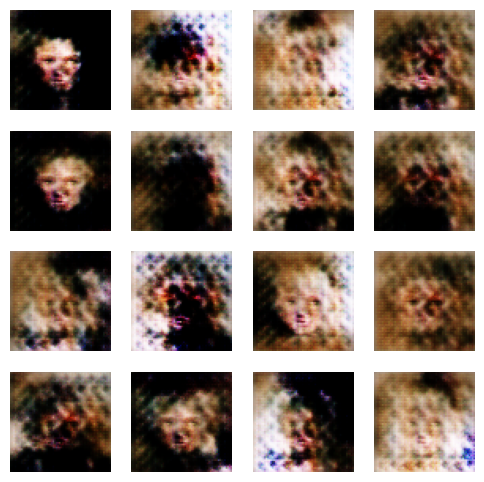

Epoch: 6, Generator Loss: 4.965391159057617, Discriminator Loss: 0.2857058346271515
Epoch: 7, Generator Loss: 4.502353668212891, Discriminator Loss: 0.34191322326660156
Epoch: 8, Generator Loss: 3.5529966354370117, Discriminator Loss: 0.4087958335876465
Epoch: 9, Generator Loss: 5.532534599304199, Discriminator Loss: 0.25143080949783325
Epoch: 10, Generator Loss: 5.133401393890381, Discriminator Loss: 0.17239664494991302


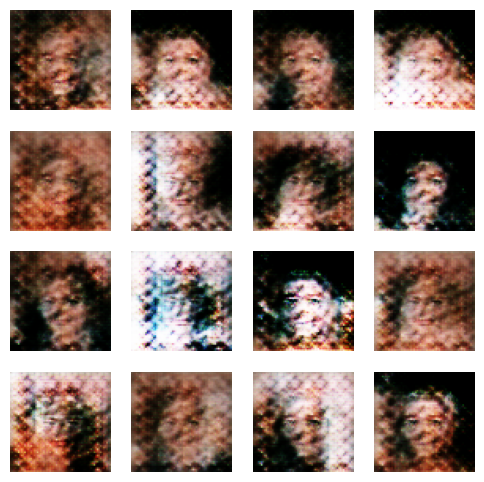

Epoch: 11, Generator Loss: 5.254446029663086, Discriminator Loss: 0.1071343868970871
Epoch: 12, Generator Loss: 3.8096728324890137, Discriminator Loss: 0.355762779712677
Epoch: 13, Generator Loss: 4.35891056060791, Discriminator Loss: 0.2177889347076416
Epoch: 14, Generator Loss: 5.100235939025879, Discriminator Loss: 0.19350075721740723
Epoch: 15, Generator Loss: 5.61099910736084, Discriminator Loss: 0.08029603958129883


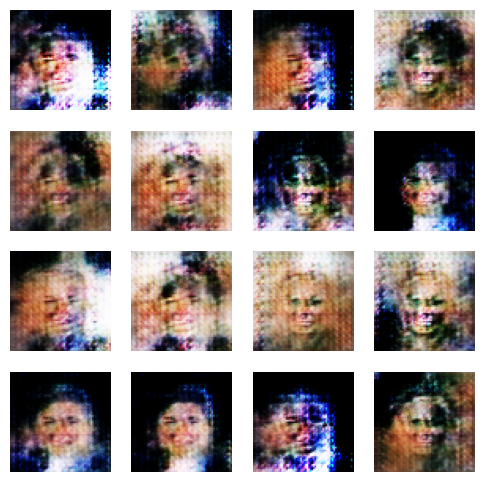

Epoch: 16, Generator Loss: 4.810670852661133, Discriminator Loss: 0.15030351281166077
Epoch: 17, Generator Loss: 3.64353609085083, Discriminator Loss: 0.24146758019924164
Epoch: 18, Generator Loss: 4.359130859375, Discriminator Loss: 0.27473050355911255
Epoch: 19, Generator Loss: 4.998317718505859, Discriminator Loss: 0.28698763251304626
Epoch: 20, Generator Loss: 3.5680599212646484, Discriminator Loss: 0.1432662159204483


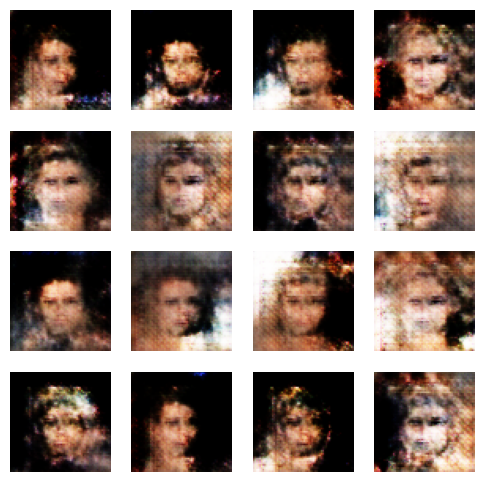

Epoch: 21, Generator Loss: 3.922084331512451, Discriminator Loss: 0.213178813457489
Epoch: 22, Generator Loss: 4.927535057067871, Discriminator Loss: 0.1096787303686142
Epoch: 23, Generator Loss: 4.744385719299316, Discriminator Loss: 0.27923911809921265
Epoch: 24, Generator Loss: 4.794002532958984, Discriminator Loss: 0.2804426848888397
Epoch: 25, Generator Loss: 4.554737567901611, Discriminator Loss: 0.13613969087600708


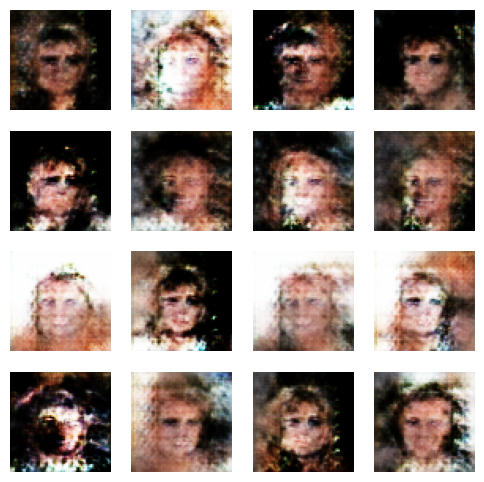

Epoch: 26, Generator Loss: 4.038473129272461, Discriminator Loss: 0.09634685516357422
Epoch: 27, Generator Loss: 4.328075408935547, Discriminator Loss: 0.5468802452087402
Epoch: 28, Generator Loss: 3.823643445968628, Discriminator Loss: 0.2975043058395386
Epoch: 29, Generator Loss: 3.8680877685546875, Discriminator Loss: 0.14521348476409912
Epoch: 30, Generator Loss: 4.738088130950928, Discriminator Loss: 0.1452968716621399


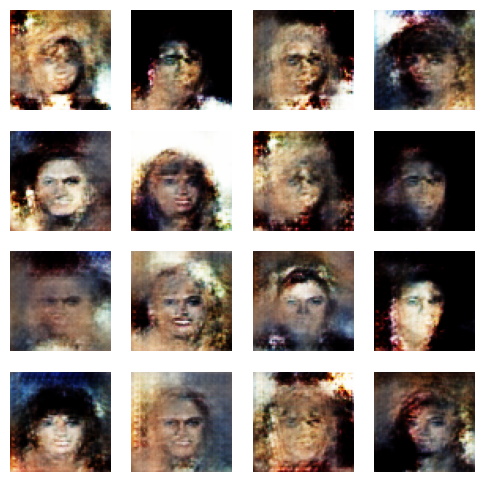

Epoch: 31, Generator Loss: 4.619170188903809, Discriminator Loss: 0.21065360307693481
Epoch: 32, Generator Loss: 3.8044605255126953, Discriminator Loss: 0.12587560713291168
Epoch: 33, Generator Loss: 3.6245017051696777, Discriminator Loss: 0.19204553961753845
Epoch: 34, Generator Loss: 4.302292823791504, Discriminator Loss: 0.22811925411224365
Epoch: 35, Generator Loss: 4.864551067352295, Discriminator Loss: 0.1405552476644516


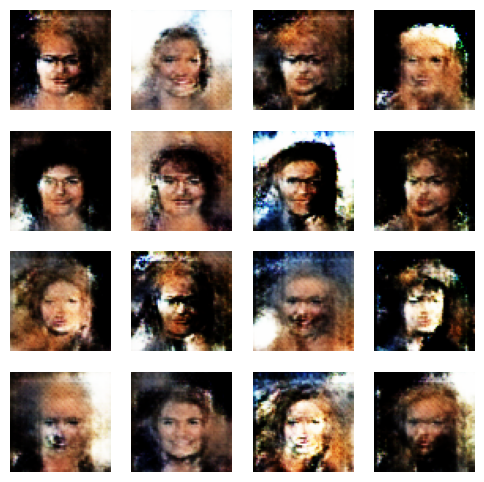

Epoch: 36, Generator Loss: 5.709430694580078, Discriminator Loss: 0.13554397225379944
Epoch: 37, Generator Loss: 3.3299312591552734, Discriminator Loss: 0.1642168164253235
Epoch: 38, Generator Loss: 3.643657684326172, Discriminator Loss: 0.1334185153245926
Epoch: 39, Generator Loss: 5.629500389099121, Discriminator Loss: 0.09806226938962936
Epoch: 40, Generator Loss: 5.399282932281494, Discriminator Loss: 0.17140884697437286


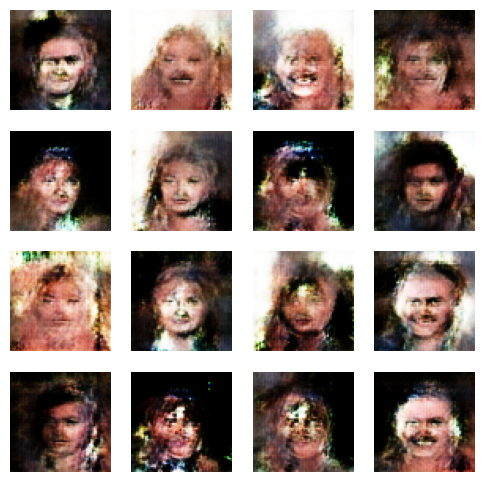

Epoch: 41, Generator Loss: 5.226357936859131, Discriminator Loss: 0.2380709946155548
Epoch: 42, Generator Loss: 3.869231700897217, Discriminator Loss: 0.1029309555888176
Epoch: 43, Generator Loss: 5.7874345779418945, Discriminator Loss: 0.07096035778522491
Epoch: 44, Generator Loss: 4.901322841644287, Discriminator Loss: 0.06298048794269562
Epoch: 45, Generator Loss: 4.7847795486450195, Discriminator Loss: 0.11485590040683746


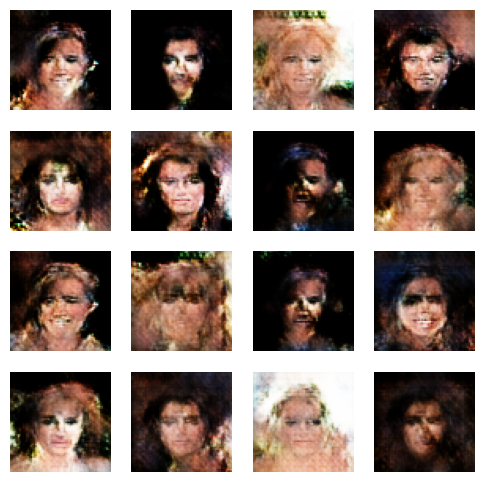

Epoch: 46, Generator Loss: 4.5559797286987305, Discriminator Loss: 0.27707719802856445
Epoch: 47, Generator Loss: 6.545047760009766, Discriminator Loss: 0.16150490939617157
Epoch: 48, Generator Loss: 5.208530426025391, Discriminator Loss: 0.2236490249633789
Epoch: 49, Generator Loss: 6.246731758117676, Discriminator Loss: 0.12200714647769928
Epoch: 50, Generator Loss: 3.4749066829681396, Discriminator Loss: 0.22716842591762543


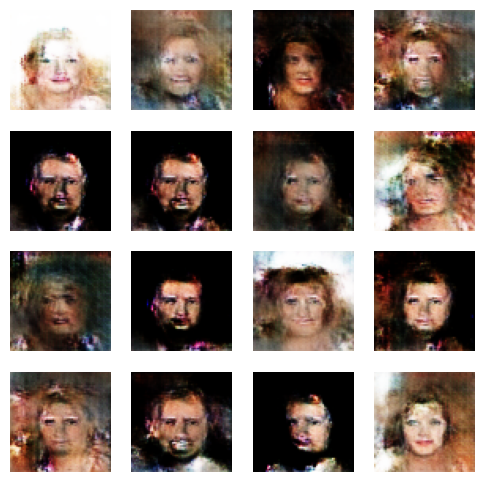

In [ ]:
EPOCHS = 50
train(train_images, EPOCHS)

In [ ]:
#progan
def load_celeba_data(batch_size, resolution, data_path='./celeba_gan/img_align_celeba', num_samples=None):
    image_paths = sorted([os.path.join(data_path, img) for img in os.listdir(data_path)])

    if num_samples:
        image_paths = image_paths[:num_samples]

    def preprocess_image(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (resolution, resolution))
        img = (img - 127.5) / 127.5
        return img

    def image_generator():
        for img_path in image_paths:
            yield preprocess_image(img_path)

    dataset = tf.data.Dataset.from_generator(image_generator, output_signature=tf.TensorSpec(shape=(resolution, resolution, 3), dtype=tf.float32))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset



In [ ]:
import os
import logging
from typing import Union, Optional, Callable, Tuple, Dict, Sequence

import tensorflow as tf
import tensorflow_datasets as tfds


def get_dataset_pipeline(
        name: str,
        split: str,
        data_dir: Union[str, os.PathLike, bytes],
        as_supervised: bool = False,
        batch_size: Optional[int] = None,
        buffer_size: Optional[int] = None,
        process_func: Optional[Callable] = None,
        map_parallel_calls: Optional[int] = None,
        interleave_parallel_calls: Optional[int] = None,
        prefetch_parallel_calls: Optional[int] = None,
        epochs: Optional[int] = None,
        caching: bool = True,
        cache_file: Union[str, os.PathLike, bytes] = "",
        **kwargs) -> tf.data.Dataset:

    # load dataset from tensorflow_datasets, apply logical chain of transformations
    dataset = tfds.load(name=name, split=split, data_dir=data_dir, as_supervised=as_supervised)
    if process_func:
        dataset = dataset.map(map_func=process_func, num_parallel_calls=map_parallel_calls)
    if batch_size:
        dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    if caching:
        dataset = dataset.cache(filename=cache_file)
    if buffer_size:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    if epochs:
        dataset = dataset.repeat(epochs)
    if buffer_size:
        dataset = dataset.prefetch(buffer_size=prefetch_parallel_calls)
    logging.info(f"Successfully loaded dataset={name} with split={split} from data_dir={data_dir}")
    return dataset


@tf.function
def celeb_a_hq_process_func(
        entry: Union[Dict[str, tf.Tensor], Sequence[tf.Tensor]],
        as_supervised: bool = False,
        mirror_augment: bool = True,
        swap_channel_axes: bool = True) -> tf.Tensor:

    image = entry['image'] if not as_supervised else entry[0]
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    if mirror_augment:
        image = tf.image.random_flip_left_right(image)
    if swap_channel_axes:
        image = tf.einsum('hwc->chw', image)
    return image

In [ ]:
def replica_train_step(batch: tf.Tensor, alpha: tf.Tensor) -> tf.Tensor:

    replica_batch_size = tf.shape(batch)[0]
    noise = tf.random.normal([replica_batch_size, conf.model.noise_dim])
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:

        fake_images = generator([noise, alpha], training=True)
        real_image_guesses = discriminator([batch, alpha], training=True)
        fake_image_guesses = discriminator([fake_images, alpha], training=True)


        if conf.train.use_gradient_penalty:
            disc_gradient_loss = wasserstein_gradient_penalty(discriminator, batch, fake_images, conf.train.wgan_target, conf.train.wgan_lambda, alpha)
            disc_gradient_loss = tf.nn.compute_average_loss(disc_gradient_loss, global_batch_size=global_batch_size)
        else:
            disc_gradient_loss = 0.0

        if conf.train.use_epsilon_penalty:
            disc_epsilon_loss = discriminator_epsilon_drift(real_image_guesses, conf.train.drift_epsilon)
            disc_epsilon_loss = tf.nn.compute_average_loss(disc_epsilon_loss, global_batch_size=global_batch_size)
        else:
            disc_epsilon_loss = 0.0

        gen_loss = wasserstein_generator_loss(fake_image_guesses)
        gen_loss = tf.nn.compute_average_loss(gen_loss, global_batch_size=global_batch_size)
        _disc_loss = wasserstein_discriminator_loss(real_image_guesses, fake_image_guesses)
        _disc_loss = tf.nn.compute_average_loss(_disc_loss, global_batch_size=global_batch_size)
        disc_stacked_loss = tf.stack((_disc_loss, disc_gradient_loss, disc_epsilon_loss))
        disc_loss = tf.reduce_sum(disc_stacked_loss)

    gradients_generator = generator_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_discriminator = discriminator_tape.gradient(disc_loss, discriminator.trainable_variables)

    optimizer_gen.apply_gradients(zip(gradients_generator, generator.trainable_variables))
    optimizer_dis.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
    return tf.stack((gen_loss, _disc_loss, disc_gradient_loss, disc_epsilon_loss))


In [ ]:
import os
import gc
import time
import logging
from typing import Tuple, Union
from datetime import timedelta

import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
from tensorflow.python.framework.composite_tensor import CompositeTensor

generator = None
final_gen = None
discriminator = None
optimizer_gen = None
optimizer_dis = None
global_batch_size = None
train_step_fn = None




def global_train_step(batch: Union[tf.Tensor, CompositeTensor], alpha: tf.Tensor) -> tf.Tensor:

    if not conf.general.train_eagerly:
        logging.info(f'tf.function tracing train_step: batch={batch}, alpha={alpha}')
    per_replica_losses = conf.general.strategy.experimental_run_v2(replica_train_step, args=(batch, alpha))
    reduced_losses = conf.general.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
    return reduced_losses


def epoch_step(dataset: tf.data.Dataset, current_epoch: int, num_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:


    _epoch_gen_loss, _epoch_dis_loss, _image_count = 0.0, 0.0, 0.0
    dataset = tqdm(iterable=dataset, desc=f"epoch-{current_epoch+1:04d}", unit="batch", total=num_steps, leave=False)

    for image_batch in dataset:
        batch_gen_loss, *batch_dis_loss = train_step_fn(image_batch, tf.constant(conf.model.alpha))
        batch_dis_loss = tf.stack(batch_dis_loss)


        transfer_weights(source_model=generator, target_model=final_gen, beta=conf.model.generator_ema)

 
        _size = tf.cast(global_batch_size, tf.float32)
        _epoch_gen_loss = (_image_count * _epoch_gen_loss + _size * batch_gen_loss) / (_image_count + _size)
        _epoch_dis_loss = (_image_count * _epoch_dis_loss + _size * batch_dis_loss) / (_image_count + _size)
        _image_count += _size


        if conf.model.use_alpha_smoothing:
            conf.model.alpha = tf.minimum(conf.model.alpha + conf.model.alpha_step * _size, 1.0)


        message = f"batch_gen_loss={batch_gen_loss:.3f}, batch_dis_loss={tf.reduce_sum(batch_dis_loss):.3f}"
        dataset.set_postfix_str(message)
        logging.debug(message)

    return _epoch_gen_loss, _epoch_dis_loss, _image_count


def instantiate_stage_objects(stage: int) -> \
        Tuple[tf.keras.Model, tf.keras.Model, tf.data.Dataset, tf.optimizers.Optimizer, tf.optimizers.Optimizer]:
    """Helper function that constructs and returns all tf/keras objects necessary for training stage 'stage'."""
    with conf.general.strategy.scope():
 
        optim_gen = tf.keras.optimizers.Adam(
            learning_rate=conf.optimizer.learning_rates[stage],
            beta_1=conf.optimizer.beta1,
            beta_2=conf.optimizer.beta2,
            epsilon=conf.optimizer.epsilon,
            name='adam_generator')
        optim_dis = tf.keras.optimizers.Adam(
            learning_rate=conf.optimizer.learning_rates[stage],
            beta_1=conf.optimizer.beta1,
            beta_2=conf.optimizer.beta2,
            epsilon=conf.optimizer.epsilon,
            name='adam_discriminator')


        batch_size = conf.data.replica_batch_sizes[stage] * conf.general.strategy.num_replicas_in_sync
        dataset = get_dataset_pipeline(name=f"{conf.data.registered_name}/{2**stage}", batch_size=batch_size,
                                       buffer_size=conf.data.buffer_sizes[stage], **conf.data)
        dataset = conf.general.strategy.experimental_distribute_dataset(dataset)

 
        gen = generator_paper(stop_stage=stage, name=f"generator_stage_{stage}", **conf.model)
        dis = discriminator_paper(stop_stage=stage, name=f"discriminator_stage_{stage}", **conf.model)


    if conf.general.is_chief and conf.general.logging:
        logging.info(f"Successfully instantiated {dis.name} and {gen.name} for stage={stage}")
        gen.summary(print_fn=logging.info, line_length=150, positions=[.33, .55, .67, 1.])
        dis.summary(print_fn=logging.info, line_length=150, positions=[.33, .55, .67, 1.])
    if conf.general.is_chief and conf.general.save:
        plot_model(gen, os.path.join(conf.general.out_dir, f"net_{gen.name}.png"), True, False, dpi=178)
        plot_model(dis, os.path.join(conf.general.out_dir, f"net_{dis.name}.png"), True, False, dpi=178)
    return gen, dis, dataset, optim_gen, optim_dis


def train():
    global optimizer_gen, optimizer_dis, global_batch_size, final_gen, generator, discriminator, train_step_fn


    with conf.general.strategy.scope():
        final_gen = generator_paper(stop_stage=conf.model.final_stage, return_all_outputs=True, **conf.model)
    logging.info(f"Successfully instantiated the following final model {final_gen.name}")
    final_gen.summary(print_fn=logging.info, line_length=150, positions=[.33, .55, .67, 1.])
    if conf.general.is_chief and conf.general.save:
        plot_model(final_gen, os.path.join(conf.general.out_dir, f"net_{final_gen.name}.png"), True, False, dpi=178)


    current_stage = 2 if conf.model.use_stages else conf.model.final_stage
    generator, discriminator, train_dataset, optimizer_gen, optimizer_dis = instantiate_stage_objects(current_stage)
    transfer_weights(source_model=generator, target_model=final_gen, beta=0.0) 
    if isinstance(train_dataset.element_spec, tf.TensorSpec):
        image_shape = train_dataset.element_spec.shape[1:]
    elif isinstance(train_dataset.element_spec, tf.python.distribute.values.PerReplicaSpec):
        image_shape = train_dataset.element_spec._value_specs[0].shape[1:]
    else:
        raise RuntimeError(f"dataset {train_dataset} returns unknown element_spec of type {type(train_dataset.element_spec)}")


    total_image_count = 0
    replica_batch_size = conf.data.replica_batch_sizes[current_stage]
    global_batch_size = replica_batch_size * conf.general.strategy.num_replicas_in_sync
    steps_per_epoch = int(conf.data.num_examples // global_batch_size)
    stage_start_time = train_start_time = time.time()
    random_noise = tf.random.normal(shape=(16, conf.model.noise_dim), seed=conf.train.random_image_seed)


    epochs = tqdm(range(conf.train.epochs), f"Progressive-GAN(stage={current_stage}, shape={image_shape}", unit='epoch')
    logging.info(f"Starting to train Stage {current_stage}")
    train_step_fn = global_train_step if conf.general.train_eagerly else tf.function(global_train_step, experimental_compile=conf.general.XLA)

    for epoch in epochs:

        epoch_start_time = time.time()
        gen_loss, dis_loss, image_count = epoch_step(train_dataset, epoch, steps_per_epoch)
        epoch_duration = time.time() - epoch_start_time
        total_image_count += int(image_count.numpy())

     
        if conf.general.is_chief and conf.general.logging and conf.general.log_freq and (epoch + 1) % conf.general.log_freq == 0:
            with conf.general.summary.as_default():
                num_replicas = conf.general.strategy.num_replicas_in_sync
                num_replicas_per_node = num_replicas / conf.general.nnodes
                batches_per_second = tf.cast(steps_per_epoch, tf.float32) / epoch_duration
                images_per_second = image_count.numpy()/epoch_duration
                seconds_per_kimages = 1000*epoch_duration/image_count.numpy()
                disc_gradient_penalty = dis_loss[1] * (conf.train.wgan_target ** 2) / conf.train.wgan_lambda
                disc_gradient_mixed_norm = np.sqrt(disc_gradient_penalty + 1e-8) + conf.train.wgan_target
                
        if conf.general.is_chief and conf.general.evaluate and conf.general.eval_freq and (epoch + 1) % conf.general.eval_freq == 0:
            n = np.minimum(replica_batch_size, len(random_noise))  # else some GPUs might OOM for large resolutions
            save_eval_images(random_noise[:n], generator, epoch, conf.general.out_dir, tf.constant(conf.model.alpha), data_format=conf.model.data_format)
            save_eval_images(random_noise[:n], final_gen, epoch, conf.general.out_dir, tf.constant(1.0), current_stage, data_format=conf.model.data_format)

   
        if conf.general.is_chief and conf.general.save and conf.general.checkpoint_freq and (epoch + 1) % conf.general.checkpoint_freq == 0:
            s = 'x'.join([str(x) for x in image_shape])
            gen_file = os.path.join(conf.general.out_dir, f"cp_{generator.name}_epoch-{epoch+1:04d}_shape-{s}.h5")
            dis_file = os.path.join(conf.general.out_dir, f"cp_{discriminator.name}_epoch-{epoch+1:04d}_shape-{s}.h5")
            fin_file = os.path.join(conf.general.out_dir, f"cp_{final_gen.name}_epoch-{epoch+1:04d}.h5")
            generator.save(filepath=gen_file)
            discriminator.save(filepath=dis_file)
            final_gen.save(filepath=fin_file)


        _str_duration = str(timedelta(seconds=epoch_duration))
        status_message = f"duration={_str_duration}, gen_loss={gen_loss:.3f}, dis_loss={tf.reduce_sum(dis_loss):.3f}"
        logging.info(f"Finished epoch-{epoch+1:04d} with {status_message}")
        epochs.set_postfix_str(status_message)

        if (epoch + 1) % conf.train.epochs_per_stage == 0 and current_stage < conf.model.final_stage:

            current_time = time.time()
            stage_duration = str(timedelta(seconds=current_time - stage_start_time))
            train_duration = str(timedelta(seconds=current_time - train_start_time))
            logging.info(f"Completed stage={current_stage} in {stage_duration}, total_train_time={train_duration}")
            stage_start_time = current_time
            current_stage += 1


            _gen, _dis, train_dataset, optimizer_gen, optimizer_dis = instantiate_stage_objects(current_stage)


            if isinstance(train_dataset.element_spec, tf.TensorSpec):
                image_shape = train_dataset.element_spec.shape[1:]
            elif isinstance(train_dataset.element_spec, tf.python.distribute.values.PerReplicaSpec):
                image_shape = train_dataset.element_spec._value_specs[0].shape[1:]
            else:
                raise RuntimeError(f"dataset {train_dataset} returns unknown element_spec of type {type(train_dataset.element_spec)}")

            transfer_weights(source_model=generator, target_model=_gen, beta=0.0)
            transfer_weights(source_model=discriminator, target_model=_dis, beta=0.0)

            del generator
            del discriminator
            gc.collect()  
            generator = _gen
            discriminator = _dis


            train_step_fn = global_train_step if conf.general.train_eagerly else tf.function(global_train_step, experimental_compile=conf.general.XLA)

            replica_batch_size = conf.data.replica_batch_sizes[current_stage]
            global_batch_size = replica_batch_size * conf.general.strategy.num_replicas_in_sync
            steps_per_epoch = int(conf.data.num_examples // global_batch_size)
            conf.model.alpha = conf.train.alpha_init
            epochs.set_description_str(f"Progressive-GAN(stage={current_stage}, shape={image_shape}")
            logging.info(f"Starting to train Stage {current_stage}")

    current_time = time.time()
    stage_duration = str(timedelta(seconds=current_time - stage_start_time))
    train_duration = str(timedelta(seconds=current_time - train_start_time))
    logging.info(f"Completed stage={current_stage} in {stage_duration}, total_train_time={train_duration}")
    logging.info(f"Successfully completed training {conf.train.epochs} epochs in {train_duration}")

Instantiate the final generator model and set the initial training stage.
Instantiate generator, discriminator, dataset, and optimizers for the current stage using instantiate_stage_objects().
Loop over the specified number of epochs:
Perform an epoch step, where the model is trained for one epoch and returns the generator and discriminator losses.
Log the losses and other training metrics.
Save evaluation images and model checkpoints periodically.
If the current stage is completed, move on to the next stage:
Instantiate new generator, discriminator, dataset, and optimizers for the next stage.
Transfer weights from the previous models to the new models.
Update the training step function, batch size, and other stage-specific configurations.
Continue training in the new stage.

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

notebook_path = os.path.join(os.getcwd(), 'MyNotebook.ipynb')
print(notebook_path)

In [ ]:
import os
import sys
import platform
from datetime import datetime

import tensorflow as tf


# ----------------------------------------------------------------------------------------------------------------------
# Convenience class that behaves exactly like dict(), but allows accessing
# the keys and values using the attribute syntax, i.e., "mydict.key = value".
# taken from: https://github.com/tkarras/progressive_growing_of_gans/blob/master/config.py#L8
# ----------------------------------------------------------------------------------------------------------------------


class EasyDict(dict):
    def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs)
    def __getattr__(self, name): return self[name]
    def __setattr__(self, name, value): self[name] = value
    def __delattr__(self, name): del self[name]


# ----------------------------------------------------------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------------------------------------------------------

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
host = platform.node()

general_config = EasyDict()             # generic configurations/options for output, checkpoints, etc.
general_config.save                     = True      # bool: de-/activates model saving and checkpointing
general_config.evaluate                 = True      # bool: de-/activates model evaluation
general_config.logging                  = True      # bool: de-/activates file logging (incl. TensorBoard)
general_config.out_dir                  = os.path.join('/media', 'storage', 'outs', f'{timestamp}-{host}')  # os.PathLike: directory for output files (images, models)
general_config.log_dir                  = os.path.join('/media', 'storage', 'outs', f'{timestamp}-{host}')  # os.PathLike: directory for logging (logfile, tensorboard)
general_config.data_dir                 = os.path.join('/media', 'storage', 'tensorflow_datasets')          # os.PathLike: directory to load tensorflow_datasets from
general_config.train_eagerly            = False     # bool: de-/activates execution of train_step in graph mode
general_config.XLA                      = False     # bool: de-/activates XLA JIT compilation for train_step
general_config.strategy                 = 'mirrored'# str: distribution strategy; options are ['mirrored', 'multimirrored'] or a device list
general_config.checkpoint_freq          = 54        # uint: epoch frequency to checkpoint models with (0 = disabled)
general_config.eval_freq                = 1         # uint: epoch frequency to evaluate models with (0 = disabled)
general_config.log_freq                 = 1         # uint: epoch frequency to log with (0 = disabled)
general_config.global_seed              = 1000      # int: global tensorflow seed

model_config = EasyDict()               # configuration of model building
model_config.leaky_alpha                = 0.2       # float: leakiness of LeakyReLU activations
model_config.generator_ema              = 0.999     # float: exponential moving average of final_generator
model_config.resolution                 = 256       # uint: final resolution in [4, 8, 16, 32, 64, 128, 256, 512, 1024]
model_config.noise_dim                  = 512       # uint: noise_dim generator projects from
model_config.epsilon                    = 1e-8      # float: small constant for numerical stability in PixelNormalization as well as StandardDeviation Layer
model_config.data_format                = 'channels_first'  # str: order of dimensions for images
model_config.use_bias                   = True      # bool: de-/activates usage of biases in all trainable layers
model_config.use_stages                 = True      # bool: de-/activates progressive training of model in stages (if deactivated only last stage for final resolution is trained)
model_config.use_fused_scaling          = True      # bool: de-/activates up- and downsampling of images via strides=(2, 2) in Conv2D and Conv2DTranspose (else UpSampling2D and AveragePooling2D is used)
model_config.use_weight_scaling         = True      # bool: de-/activates the weight scaling trick on Conv and Dense layers as proposed in https://arxiv.org/abs/1710.10196
model_config.use_alpha_smoothing        = True      # bool: de-/activates smoothing in an image from a previous block after increasing the model to a new stage as proposed in https://arxiv.org/abs/1710.10196
model_config.use_noise_normalization    = True      # bool: de-/activates pixel_normalization on noise input at generator start

train_config = EasyDict()               # configuration of train parameters
train_config.epochs                     = 432       # uint: number of epochs to train for
train_config.epochs_per_stage           = 54        # uint: number of epochs per stage; alpha is increased linearly from alpha_init to 1.0 in halfway through
train_config.alpha_init                 = 0.0       # float: initial alpha value to smooth in images from previous block after stage in model has been increased
train_config.use_epsilon_penalty        = True      # bool: de-/activates epsilon_drift_penalty applied to discriminator loss as described in https://arxiv.org/abs/1710.10196
train_config.drift_epsilon              = 0.001     # float: epsilon scalar for epsilon_drift_penalty as described in https://arxiv.org/abs/1710.10196
train_config.use_gradient_penalty       = True      # bool: de-/activates gradient_penalty applied to discriminator loss as described in https://arxiv.org/abs/1704.00028
train_config.wgan_lambda                = 10.0      # float: lambda scalar for gradient_penalty as described in https://arxiv.org/abs/1704.00028
train_config.wgan_target                = 1.0       # float: target scalar for gradient_penalty as described in https://arxiv.org/abs/1704.00028
train_config.random_image_seed          = 42        # int: seed for fixed-random evaluate images

data_config = EasyDict()                # configuration of data set pipeline
data_config.registered_name             = 'celeb_a_hq'                   # str: name argument for tensorflow_datasets.load
data_config.split                       = 'train'                        # str: split argument for tensorflow_datasets.load
data_config.num_examples                = 30000                          # uint: number of examples train dataset will contain according to loaded split
data_config.caching                     = False                          # bool: de-/activates dataset caching to file or system memory (see cache_file)
data_config.cache_file                  = os.path.join('/tmp', f'{timestamp}-tf-dataset.cache')  # os.PathLike: ignored if caching is false, else location of temporary cache_file ("" = load entire dataset into system memory)
data_config.process_func                = celeb_a_hq_process_func        # callable: function to process each dataset entry with
data_config.map_parallel_calls          = tf.data.experimental.AUTOTUNE  # int: number of parallel entries to apply 'process_functions' asynchronously
data_config.prefetch_parallel_calls     = tf.data.experimental.AUTOTUNE  # int: number of parallel threads to prefetch entries with concurrently
data_config.interleave_parallel_calls   = tf.data.experimental.AUTOTUNE  # int: number of parallel threads to access dataset shards/files
data_config.replica_batch_sizes         = {2: 128, 3: 128, 4: 128, 5: 64, 6: 32, 7: 16, 8: 8, 9: 6, 10: 4}               # dict: batch_size at stage
data_config.buffer_sizes                = {2: 5000, 3: 5000, 4: 2500, 5: 1250, 6: 500, 7: 400, 8: 300, 9: 250, 10: 200}  # dict: buffer_size at stage

optimizer_config = EasyDict()           # configuration of adam optimizers for both generator and discriminator
optimizer_config.learning_rates         = {2: 1e-3, 3: 1e-3, 4: 1e-3, 5: 1e-3, 6: 1e-3, 7: 1e-3, 8: 1e-3, 9: 1e-3, 10: 1e-3}  # dict: learning_rate at stage
optimizer_config.beta1                  = 0.0   # float: exponential decay rate for the 1st moment estimates
optimizer_config.beta2                  = 0.99  # float: exponential decay rate for the 2nd moment estimates
optimizer_config.epsilon                = 1e-8  # float: small constant for numerical stability

log_config = EasyDict()                 # configuration of general purpose logging
log_config.device_placement             = False   # bool: de-/activates TensorFlow device placement
log_config.level                        = 'INFO'  # str: log level of project logger; options are ['INFO', 'CRITICAL', 'ERROR', 'WARNING', 'DEBUG', 'NOTSET']
log_config.filename                     = f'{timestamp}-{host}-logfile.log'                         # str: name of resulting log file
log_config.format                       = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'    # str: log formatting for formatter
log_config.datefmt                      = '%m/%d/%Y %I:%M:%S %p'                                    # str: datetime formatting for formatter
log_config.adapt_tf_logger              = True    # bool: de-/activates overriding of tf_logger configuration
log_config.tf_level                     = 'ERROR' # str: log level of TensorFlow logging logger; options are ['INFO', 'CRITICAL', 'ERROR', 'WARNING', 'DEBUG', 'NOTSET']

conf = EasyDict()                       # configuration summary
conf.general                            = general_config
conf.model                              = model_config
conf.train                              = train_config
conf.data                               = data_config
conf.optimizer                          = optimizer_config
conf.log                                = log_config
# Create distribution strategy
if conf.general.strategy == 'mirrored':
    conf.general.strategy = tf.distribute.MirroredStrategy()
elif conf.general.strategy == 'multimirrored':
    conf.general.strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
else:
    raise ValueError("Invalid distribution strategy specified.")


# uncomment next line to apply full training according to the original contribution: https://arxiv.org/abs/1710.10196
# model_config.resolution = 1024; train_config.epochs = 540

# laptop config
# general_config.out_dir = os.path.join(os.getcwd(), 'outs', f'{timestamp}-{host}'); general_config.log_dir = os.path.join(os.getcwd(), 'outs', f'{timestamp}-{host}'); general_config.data_dir = os.path.abspath(os.path.realpath(os.path.expanduser('~/tensorflow_datasets'))); data_config.split = 'train[:2%]'; data_config.num_examples = 600; model_config.resolution = 32; train_config.epochs = 20; train_config.epochs_per_stage = 5; data_config.replica_batch_sizes = {2: 32, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 14, 9: 6, 10: 3};

# benchmark config
# general_config.save = False; general_config.evaluate = False; general_config.strategy = "mirrored"; data_config.split = 'train[:10%]'; data_config.num_examples = 3000; model_config.resolution = 1024; train_config.epochs = 20; train_config.epochs_per_stage = 2;

# ----------------------------------------------------------------------------------------------------------------------
# Placeholders (these configurations are automatically set at runtime)
# ----------------------------------------------------------------------------------------------------------------------

general_config.source_dir               = os.path.abspath(os.path.realpath(os.path.expanduser(sys.path[0])))
general_config.working_dir              = os.path.abspath(os.path.realpath(os.path.expanduser(os.getcwd())))
general_config.config_file              = os.path.abspath(os.path.realpath(os.path.expanduser(notebook_path)))
general_config.is_chief                 = None  # bool: whether or not local machine is chief worker
general_config.is_cluster               = None  # bool: whether or not project is run in cluster
general_config.nnodes                   = None  # uint: number of nodes training
general_config.summary                  = None  # tf.FileWriter: FileWriter instance for TensorBoard logging (only for chief)
data_config.data_dir                    = 'celeba-gan'  # str: path to data_dir (same as general_config.data_dir)
model_config.final_stage                = 5  # uint: final model stage
model_config.alpha                      = None  # uint: current alpha for smoothing
model_config.alpha_step                 = None  # float: delta-alpha increase per image during training


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Change output and logging directories to save results and logs to Google Drive
general_config.out_dir = os.path.join('/content/gdrive/My Drive', 'outs', f'{timestamp}-{host}')
general_config.log_dir = os.path.join('/content/gdrive/My Drive', 'outs', f'{timestamp}-{host}')

# Set smaller number of epochs and smaller resolution for model
train_config.epochs = 50
model_config.resolution = 64


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install tensorflow-datasets




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_datasets as tfds

def celeb_a_hq_process_func(entry):
    # Preprocessing function for CelebA dataset
    pass

data_config.process_func = celeb_a_hq_process_func

In [ ]:
train()

AssertionError: ignored

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend

FILTERS = [512, 512, 512, 512, 256, 128, 64]


# Normalizes the feature vector for the pixel(axis=-1)
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
        l2 = tf.math.rsqrt(mean_square + 1.0e-8)
        normalized = inputs * l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape

# Calculate the average standard deviation of all features and spatial location.
# Concat after creating a constant feature map with the average standard deviation
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)
    
    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
        average_stddev = tf.reduce_mean(stddev, keepdims=True)
        shape = tf.shape(inputs)
        minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
        combined = tf.concat([inputs, minibatch_stddev], axis=-1)
        
        return combined
    
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

# Perform Weighted Sum
# Define alpha as backend.variable to update during training
class WeightedSum(Add):
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')
    
    def _merge_function(self, inputs):
        assert (len(inputs) == 2)
        output = ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))
        return output

# Scale by the number of input parameters to be similar dynamic range  
# For details, refer to https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
# stddev = sqrt(2 / fan_in)
class WeightScaling(Layer):
    def __init__(self, shape, gain = np.sqrt(2), **kwargs):
        super(WeightScaling, self).__init__(**kwargs)
        shape = np.asarray(shape)
        shape = tf.constant(shape, dtype=tf.float32)
        fan_in = tf.math.reduce_prod(shape)
        self.wscale = gain*tf.math.rsqrt(fan_in)
      
    def call(self, inputs, **kwargs):
        inputs = tf.cast(inputs, tf.float32)
        return inputs * self.wscale
    
    def compute_output_shape(self, input_shape):
        return input_shape

class Bias(Layer):
    def __init__(self, **kwargs):
        super(Bias, self).__init__(**kwargs)

    def build(self, input_shape):
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(initial_value = b_init(shape=(input_shape[-1],), dtype='float32'), trainable=True)  

    def call(self, inputs, **kwargs):
        return inputs + self.bias
    
    def compute_output_shape(self, input_shape):
        return input_shape  

def WeightScalingDense(x, filters, gain, use_pixelnorm=False, activate=None):
    init = RandomNormal(mean=0., stddev=1.)
    in_filters = backend.int_shape(x)[-1]
    x = layers.Dense(filters, use_bias=False, kernel_initializer=init, dtype='float32')(x)
    x = WeightScaling(shape=(in_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    if activate=='LeakyReLU':
        x = layers.LeakyReLU(0.2)(x)
    elif activate=='tanh':
        x = layers.Activation('tanh')(x)
    
    if use_pixelnorm:
        x = PixelNormalization()(x)
    return x

def WeightScalingConv(x, filters, kernel_size, gain, use_pixelnorm=False, activate=None, strides=(1,1)):
    init = RandomNormal(mean=0., stddev=1.)
    in_filters = backend.int_shape(x)[-1]
    x = layers.Conv2D(filters, kernel_size, strides=strides, use_bias=False, padding="same", kernel_initializer=init, dtype='float32')(x)
    x = WeightScaling(shape=(kernel_size[0], kernel_size[1], in_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    if activate=='LeakyReLU':
        x = layers.LeakyReLU(0.2)(x)
    elif activate=='tanh':
        x = layers.Activation('tanh')(x)
    
    if use_pixelnorm:
        x = PixelNormalization()(x)
    return x 

# https://keras.io/examples/generative/wgan_gp/
class PGAN(Model):
    def __init__(
        self,
        latent_dim,
        d_steps=1,
        gp_weight=10.0,
        drift_weight=0.001,
    ):
        super(PGAN, self).__init__()
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        self.n_depth = 0
        self.discriminator = self.init_discriminator()
        self.discriminator_wt_fade = None
        self.generator = self.init_generator()
        self.generator_wt_fade = None

    def call(self, inputs):
        return

    def init_discriminator(self):
        img_input = layers.Input(shape = (4,4,3))
        img_input = tf.cast(img_input, tf.float32)
        
        # fromRGB
        x = WeightScalingConv(img_input, filters=FILTERS[0], kernel_size=(1,1), gain=np.sqrt(2), activate='LeakyReLU')
        
        # Add Minibatch end of discriminator
        x = MinibatchStdev()(x)

        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')
        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', strides=(4,4))

        x = layers.Flatten()(x)
        # Gain should be 1, cos it's a last layer 
        x = WeightScalingDense(x, filters=1, gain=1.)

        d_model = Model(img_input, x, name='discriminator')

        return d_model

    # Fade in upper resolution block
    def fade_in_discriminator(self):
        #for layer in self.discriminator.layers:
        #    layer.trainable = False
        input_shape = list(self.discriminator.input.shape)
        # 1. Double the input resolution. 
        input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])
        img_input = layers.Input(shape = input_shape)
        img_input = tf.cast(img_input, tf.float32)

        # 2. Add pooling layer 
        #    Reuse the existing “formRGB” block defined as “x1".
        x1 = layers.AveragePooling2D()(img_input)
        x1 = self.discriminator.layers[1](x1) # Conv2D FromRGB
        x1 = self.discriminator.layers[2](x1) # WeightScalingLayer
        x1 = self.discriminator.layers[3](x1) # Bias
        x1 = self.discriminator.layers[4](x1) # LeakyReLU

        # 3.  Define a "fade in" block (x2) with a new "fromRGB" and two 3x3 convolutions. 
        #     Add an AveragePooling2D layer
        x2 = WeightScalingConv(img_input, filters=FILTERS[self.n_depth], kernel_size=(1,1), gain=np.sqrt(2), activate='LeakyReLU')

        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')
        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth-1], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')

        x2 = layers.AveragePooling2D()(x2)

        # 4. Weighted Sum x1 and x2 to smoothly put the "fade in" block. 
        x = WeightedSum()([x1, x2])

        # Define stabilized(c. state) discriminator 
        for i in range(5, len(self.discriminator.layers)):
            x2 = self.discriminator.layers[i](x2)
        self.discriminator_stabilize = Model(img_input, x2, name='discriminator')

        # 5. Add existing discriminator layers. 
        for i in range(5, len(self.discriminator.layers)):
            x = self.discriminator.layers[i](x)
        self.discriminator = Model(img_input, x, name='discriminator')

        self.discriminator.summary()



    # Change to stabilized(c. state) discriminator 
    def stabilize_discriminator(self):
        self.discriminator = self.discriminator_stabilize
        self.discriminator.summary()


    def init_generator(self):
        noise = layers.Input(shape=(self.latent_dim,))
        x = PixelNormalization()(noise)
        # Actual size(After doing reshape) is just FILTERS[0], so divide gain by 4
        x = WeightScalingDense(x, filters=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)
        x = layers.Reshape((4, 4, FILTERS[0]))(x)

        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)

        # Add "toRGB", the original paper uses linear as actiavation. 
        # Gain should be 1, cos it's a last layer 
        x = WeightScalingConv(x, filters=3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)

        g_model = Model(noise, x, name='generator')
        g_model.summary()
        return g_model

    # Fade in upper resolution block
    def fade_in_generator(self):
        #for layer in self.generator.layers:
        #    layer.trainable = False
        # 1. Get the node above the “toRGB” block 
        block_end = self.generator.layers[-5].output
        # 2. Double block_end       
        block_end = layers.UpSampling2D((2,2))(block_end)

        # 3. Reuse the existing “toRGB” block defined as“x1”. 
        x1 = self.generator.layers[-4](block_end) # Conv2d
        x1 = self.generator.layers[-3](x1) # WeightScalingLayer
        x1 = self.generator.layers[-2](x1) # Bias
        x1 = self.generator.layers[-1](x1) #tanh

        # 4. Define a "fade in" block (x2) with two 3x3 convolutions and a new "toRGB".
        x2 = WeightScalingConv(block_end, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        
        x2 = WeightScalingConv(x2, filters=3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)

        # Define stabilized(c. state) generator
        self.generator_stabilize = Model(self.generator.input, x2, name='generator')

        # 5.Then "WeightedSum" x1 and x2 to smoothly put the "fade in" block.
        x = WeightedSum()([x1, x2])
        self.generator = Model(self.generator.input, x, name='generator')

        self.generator.summary()



    # Change to stabilized(c. state) generator 
    def stabilize_generator(self):
        self.generator = self.generator_stabilize

        self.generator.summary()


    def compile(self, d_optimizer, g_optimizer):
        super(PGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0.0, maxval=1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]
        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)

                # Calculate the drift for regularization
                drift = tf.reduce_mean(tf.square(real_logits))

                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = -tf.reduce_mean(gen_img_logits)
        # Get the gradients w.r.t the generator loss
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot
from math import sqrt
from PIL import Image
import os


from tensorflow.keras import backend

# Create a Keras callback that periodically saves generated images and updates alpha in WeightedSum layers
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=16, latent_dim=512, prefix=''):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.random_latent_vectors = tf.random.normal(shape=[num_img, self.latent_dim], seed=9434)
    self.steps_per_epoch = 0
    self.epochs = 0
    self.steps = self.steps_per_epoch * self.epochs
    self.n_epoch = 0
    self.prefix = prefix
  
  def set_prefix(self, prefix=''):
    self.prefix = prefix
  
  def set_steps(self, steps_per_epoch, epochs):
    self.steps_per_epoch = steps_per_epoch
    self.epochs = epochs
    self.steps = self.steps_per_epoch * self.epochs

  def on_epoch_begin(self, epoch, logs=None):
    self.n_epoch = epoch


  def on_epoch_end(self, epoch, logs=None):
    samples = self.model.generator(self.random_latent_vectors)
    samples = (samples * 0.5) + 0.5
    n_grid = int(sqrt(self.num_img))

    fig, axes = pyplot.subplots(n_grid, n_grid, figsize=(4*n_grid, 4*n_grid))
    sample_grid = np.reshape(samples[:n_grid * n_grid], (n_grid, n_grid, samples.shape[1], samples.shape[2], samples.shape[3]))

    for i in range(n_grid):
      for j in range(n_grid):
        axes[i][j].set_axis_off()
        samples_grid_i_j = Image.fromarray((sample_grid[i][j] * 255).astype(np.uint8))
        samples_grid_i_j = samples_grid_i_j.resize((128,128))
        axes[i][j].imshow(np.array(samples_grid_i_j))
    title = f'images/plot_{self.prefix}_{epoch:05d}.png'
    pyplot.savefig(title, bbox_inches='tight')
    print(f'\n saved {title}')
    pyplot.close(fig)
  

  def on_batch_begin(self, batch, logs=None):
    # Update alpha in WeightedSum layers
    alpha = ((self.n_epoch * self.steps_per_epoch) + batch) / float(self.steps - 1)
    #print(f'\n {self.steps}, {self.n_epoch}, {self.steps_per_epoch}, {alpha}')
    for layer in self.model.generator.layers:
      if isinstance(layer, WeightedSum):
        backend.set_value(layer.alpha, alpha)
    for layer in self.model.discriminator.layers:
      if isinstance(layer, WeightedSum):
        backend.set_value(layer.alpha, alpha)


# DEFINE FILEPATH AND PARAMETERS
# can use celeb A mask dataset on https://github.com/switchablenorms/CelebAMask-HQ 
DATA_ROOT = './CelebAMask-HQ' 
NOISE_DIM = 512
# Set the number of batches, epochs and steps for trainining.
# Look 800k images(16x50x1000) per each lavel
BATCH_SIZE = [16, 16, 16, 16, 16, 16, 4]
EPOCHS = 50
STEPS_PER_EPOCH = 1000





# Normalilze [-1, 1] input images
def preprocessing_image(img):
  img = img.astype('float32')
  img = (img - 127.5) / 127.5
  return img




import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

class CustomDirectoryIterator(DirectoryIterator):
    def __init__(self, *args, max_samples=None, **kwargs):
        self.max_samples = max_samples
        super().__init__(*args, **kwargs)
        if self.max_samples is not None:
            self.n = min(self.n, self.max_samples)
            self.samples = self.n

MAX_SAMPLES = 50

train_image_generator = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocessing_image)
train_dataset = CustomDirectoryIterator(
    directory=DATA_ROOT,
    image_data_generator=train_image_generator,
    batch_size=BATCH_SIZE[0],
    target_size=(4,4),
    class_mode='binary',
    shuffle=True,
    max_samples=MAX_SAMPLES
)


# Instantiate the optimizer for both networks
# learning_rate will be equalized per each layers by the WeightScaling scheme
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)




cbk = GANMonitor(num_img=64, latent_dim=NOISE_DIM, prefix='0_init')
cbk.set_steps(steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# Instantiate the PGAN(PG-GAN) model.
pgan = PGAN(
    latent_dim = NOISE_DIM, 
    d_steps = 1,
)

checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"

# Compile models
pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

print(len(train_dataset))
# Draw models
tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{pgan.n_depth}.png', show_shapes=True)
tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{pgan.n_depth}.png', show_shapes=True)

# Start training the initial generator and discriminator
pgan.fit(train_dataset, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, callbacks=[cbk])
pgan.save_weights(checkpoint_path)

# Train faded-in / stabilized generators and discriminators
for n_depth in range(1, 7):
  # Set current level(depth)
  pgan.n_depth = n_depth

  # Set parameters like epochs, steps, batch size and image size
  steps_per_epoch = STEPS_PER_EPOCH
  epochs = int(EPOCHS*(BATCH_SIZE[0]/BATCH_SIZE[n_depth]))
  DATA_ROOT = f'dd/{n_depth}'
  train_dataset = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE[n_depth],
                                                          directory=DATA_ROOT,
                                                          shuffle=True,
                                                          target_size=(4*(2**n_depth), 4*(2**n_depth)),
                                                          class_mode='binary')
  cbk.set_prefix(prefix=f'{n_depth}_fade_in')
  cbk.set_steps(steps_per_epoch=steps_per_epoch, epochs=epochs)

  # Put fade in generator and discriminator
  pgan.fade_in_generator()
  pgan.fade_in_discriminator()

  # Draw fade in generator and discriminator
  tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{n_depth}_fade_in.png', show_shapes=True)
  tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{n_depth}_fade_in.png', show_shapes=True)

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  # Train fade in generator and discriminator
  pgan.fit(train_dataset, steps_per_epoch = steps_per_epoch, epochs = epochs, callbacks=[cbk])
  # Save models
  checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"
  pgan.save_weights(checkpoint_path)

  # Change to stabilized generator and discriminator
  cbk.set_prefix(prefix=f'{n_depth}_stabilize')
  pgan.stabilize_generator()
  pgan.stabilize_discriminator()

  # Draw stabilized generator and discriminator
  tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{n_depth}_stabilize.png', show_shapes=True)
  tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{n_depth}_stabilize.png', show_shapes=True)
  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  # Train stabilized generator and discriminator
  pgan.fit(train_dataset, steps_per_epoch = steps_per_epoch, epochs = epochs, callbacks=[cbk])
  # Save models
  checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"
  pgan.save_weights(checkpoint_path)


Found 402767 images belonging to 3 classes.
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 512)]             0         
                                                                 
 pixel_normalization_70 (Pix  (None, 512)              0         
 elNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 8192)              4194304   
                                                                 
 weight_scaling_150 (WeightS  (None, 8192)             0         
 caling)                                                         
                                                                 
 bias_150 (Bias)             (None, 8192)              8192      
                                                                 
 leaky_re_lu_


 saved images/plot_0_init_00000.png
1000/1000 [==============================] - 11s 6ms/step - d_loss: -0.8714 - g_loss: 1.1070
Found 30000 images belonging to 1 classes.
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 pixel_normalization_70 (PixelN  (None, 512)         0           ['input_60[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dense_33 (Dense)               (None, 8192)         4194304     ['pixel_normalization_70[0][0]'] 
                

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot
from math import sqrt
from PIL import Image
import os


from tensorflow.keras import backend

def saveSample(generator, random_latent_vectors, prefix):
  samples = generator(random_latent_vectors)
  samples = (samples * 0.5) + 0.5
  n_grid = int(sqrt(random_latent_vectors.shape[0]))

  fig, axes = pyplot.subplots(n_grid, n_grid, figsize=(8*n_grid, 8*n_grid))
  sample_grid = np.reshape(samples[:n_grid * n_grid], (n_grid, n_grid, samples.shape[1], samples.shape[2], samples.shape[3]))

  for i in range(n_grid):
    for j in range(n_grid):
      axes[i][j].set_axis_off()
      samples_grid_i_j = Image.fromarray((sample_grid[i][j] * 255).astype(np.uint8))
      samples_grid_i_j = samples_grid_i_j.resize((256,256))
      axes[i][j].imshow(np.array(samples_grid_i_j))
  title = f'test/plot_{prefix}_{0:05d}.png'
  pyplot.savefig(title, bbox_inches='tight')
  print(f'\n saved {title}')
  pyplot.close(fig)




NOISE_DIM = 512
NUM_SAMPLE = 4
random_latent_vectors = tf.random.normal(shape=[NUM_SAMPLE, NOISE_DIM])#, seed=9434)

# Instantiate the PGAN(PG-GAN) model.
pgan = PGAN(
    latent_dim = NOISE_DIM, 
    d_steps = 1,
)

# Load weight and generate samples per each level. 
prefix='0_init'
pgan.load_weights(f"ckpts/pgan_{prefix}.ckpt")
saveSample(pgan.generator, random_latent_vectors, prefix)

#inference
for n_depth in range(1,7):
  pgan.n_depth = n_depth
  prefix=f'{n_depth}_fade_in'
  pgan.fade_in_generator()
  pgan.fade_in_discriminator()

  pgan.load_weights(f"ckpts/pgan_{prefix}.ckpt")
  saveSample(pgan.generator, random_latent_vectors, prefix)

  prefix=f'{n_depth}_stabilize'
  pgan.stabilize_generator()
  pgan.stabilize_discriminator()

  pgan.load_weights(f"ckpts/pgan_{prefix}.ckpt")
  saveSample(pgan.generator, random_latent_vectors, prefix)
pgan.load_weights(f"ckpts/pgan_{prefix}.ckpt")


# Generate interpolated samples. 
sample_0 = tf.random.normal(shape=[NUM_SAMPLE, NOISE_DIM], seed = 4311)
sample_1 = tf.random.normal(shape=[NUM_SAMPLE, NOISE_DIM], seed = 55)

steps = 120
dt = (sample_0 - sample_1)/steps
for i in range(1, steps+1):
    random_latent_vectors = sample_0 + dt*i
    print(random_latent_vectors[:4])
    prefix = f'{i:03d}'
    saveSample(pgan.generator, random_latent_vectors, prefix)


In [ ]:
from PIL import Image
import os

input_folder = "CelebAMask-HQ/CelebA-HQ-img"
output_folder = "CelebAMask-HQ"

resolutions = [8, 16, 32, 64, 128, 256]
total_images = len(os.listdir(input_folder))
processed_images = 0
for i in range(1, 7):
    resolution_folder = os.path.join(output_folder, f"CelebA-HQ-{i}")
    os.makedirs(resolution_folder, exist_ok=True)
for image_name in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, image_name)
    original_image = Image.open(input_image_path)

    for i, resolution in enumerate(resolutions):
        resized_image = original_image.resize((resolution, resolution))
        output_directory = os.path.join(output_folder, f"CelebA-HQ-{i+1}")
        output_image_path = os.path.join(output_directory, image_name)
        resized_image.save(output_image_path)

    processed_images += 1
    print(f"Processed {processed_images}/{total_images} images")

print(f"Total images copied: {total_images}")


Streaming output truncated to the last 5000 lines.
Processed 25002/30000 images
Processed 25003/30000 images
Processed 25004/30000 images
Processed 25005/30000 images
Processed 25006/30000 images
Processed 25007/30000 images
Processed 25008/30000 images
Processed 25009/30000 images
Processed 25010/30000 images
Processed 25011/30000 images
Processed 25012/30000 images
Processed 25013/30000 images
Processed 25014/30000 images
Processed 25015/30000 images
Processed 25016/30000 images
Processed 25017/30000 images
Processed 25018/30000 images
Processed 25019/30000 images
Processed 25020/30000 images
Processed 25021/30000 images
Processed 25022/30000 images
Processed 25023/30000 images
Processed 25024/30000 images
Processed 25025/30000 images
Processed 25026/30000 images
Processed 25027/30000 images
Processed 25028/30000 images
Processed 25029/30000 images
Processed 25030/30000 images
Processed 25031/30000 images
Processed 25032/30000 images
Processed 25033/30000 images
Processed 25034/30000

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend

FILTERS = [512, 512, 512, 512, 256, 128, 64]


# Normalizes the feature vector for the pixel(axis=-1)
class PixelNormalization(Layer):
    def __init__(self, **kwargs):
        super(PixelNormalization, self).__init__(**kwargs)

    def call(self, inputs):
        mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
        l2 = tf.math.rsqrt(mean_square + 1.0e-8)
        normalized = inputs * l2
        return normalized

    def compute_output_shape(self, input_shape):
        return input_shape

# Calculate the average standard deviation of all features and spatial location.
# Concat after creating a constant feature map with the average standard deviation
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)
    
    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
        average_stddev = tf.reduce_mean(stddev, keepdims=True)
        shape = tf.shape(inputs)
        minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
        combined = tf.concat([inputs, minibatch_stddev], axis=-1)
        
        return combined
    
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

# Perform Weighted Sum
# Define alpha as backend.variable to update during training
class WeightedSum(Add):
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = backend.variable(alpha, name='ws_alpha')
    
    def _merge_function(self, inputs):
        assert (len(inputs) == 2)
        output = ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))
        return output

# Scale by the number of input parameters to be similar dynamic range  
# For details, refer to https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
# stddev = sqrt(2 / fan_in)
class WeightScaling(Layer):
    def __init__(self, shape, gain = np.sqrt(2), **kwargs):
        super(WeightScaling, self).__init__(**kwargs)
        shape = np.asarray(shape)
        shape = tf.constant(shape, dtype=tf.float32)
        fan_in = tf.math.reduce_prod(shape)
        self.wscale = gain*tf.math.rsqrt(fan_in)
      
    def call(self, inputs, **kwargs):
        inputs = tf.cast(inputs, tf.float32)
        return inputs * self.wscale
    
    def compute_output_shape(self, input_shape):
        return input_shape

class Bias(Layer):
    def __init__(self, **kwargs):
        super(Bias, self).__init__(**kwargs)

    def build(self, input_shape):
        b_init = tf.zeros_initializer()
        self.bias = tf.Variable(initial_value = b_init(shape=(input_shape[-1],), dtype='float32'), trainable=True)  

    def call(self, inputs, **kwargs):
        return inputs + self.bias
    
    def compute_output_shape(self, input_shape):
        return input_shape  

def WeightScalingDense(x, filters, gain, use_pixelnorm=False, activate=None):
    init = RandomNormal(mean=0., stddev=1.)
    in_filters = backend.int_shape(x)[-1]
    x = layers.Dense(filters, use_bias=False, kernel_initializer=init, dtype='float32')(x)
    x = WeightScaling(shape=(in_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    if activate=='LeakyReLU':
        x = layers.LeakyReLU(0.2)(x)
    elif activate=='tanh':
        x = layers.Activation('tanh')(x)
    
    if use_pixelnorm:
        x = PixelNormalization()(x)
    return x

def WeightScalingConv(x, filters, kernel_size, gain, use_pixelnorm=False, activate=None, strides=(1,1)):
    init = RandomNormal(mean=0., stddev=1.)
    in_filters = backend.int_shape(x)[-1]
    x = layers.Conv2D(filters, kernel_size, strides=strides, use_bias=False, padding="same", kernel_initializer=init, dtype='float32')(x)
    x = WeightScaling(shape=(kernel_size[0], kernel_size[1], in_filters), gain=gain)(x)
    x = Bias(input_shape=x.shape)(x)
    if activate=='LeakyReLU':
        x = layers.LeakyReLU(0.2)(x)
    elif activate=='tanh':
        x = layers.Activation('tanh')(x)
    
    if use_pixelnorm:
        x = PixelNormalization()(x)
    return x 

# https://keras.io/examples/generative/wgan_gp/
class PGAN(Model):
    def __init__(
        self,
        latent_dim,
        d_steps=1,
        gp_weight=10.0,
        drift_weight=0.001,
    ):
        super(PGAN, self).__init__()
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        self.n_depth = 0
        self.discriminator = self.init_discriminator()
        self.discriminator_wt_fade = None
        self.generator = self.init_generator()
        self.generator_wt_fade = None

    def call(self, inputs):
        return

    def init_discriminator(self):
        img_input = layers.Input(shape = (4,4,3))
        img_input = tf.cast(img_input, tf.float32)
        
        # fromRGB
        x = WeightScalingConv(img_input, filters=FILTERS[0], kernel_size=(1,1), gain=np.sqrt(2), activate='LeakyReLU')
        
        # Add Minibatch end of discriminator
        x = MinibatchStdev()(x)

        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')
        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', strides=(4,4))

        x = layers.Flatten()(x)
        # Gain should be 1, cos it's a last layer 
        x = WeightScalingDense(x, filters=1, gain=1.)

        d_model = Model(img_input, x, name='discriminator')

        return d_model

    # Fade in upper resolution block
    def fade_in_discriminator(self):
        #for layer in self.discriminator.layers:
        #    layer.trainable = False
        input_shape = list(self.discriminator.input.shape)
        # 1. Double the input resolution. 
        input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])
        img_input = layers.Input(shape = input_shape)
        img_input = tf.cast(img_input, tf.float32)

        # 2. Add pooling layer 
        #    Reuse the existing “formRGB” block defined as “x1".
        x1 = layers.AveragePooling2D()(img_input)
        x1 = self.discriminator.layers[1](x1) # Conv2D FromRGB
        x1 = self.discriminator.layers[2](x1) # WeightScalingLayer
        x1 = self.discriminator.layers[3](x1) # Bias
        x1 = self.discriminator.layers[4](x1) # LeakyReLU

        # 3.  Define a "fade in" block (x2) with a new "fromRGB" and two 3x3 convolutions. 
        #     Add an AveragePooling2D layer
        x2 = WeightScalingConv(img_input, filters=FILTERS[self.n_depth], kernel_size=(1,1), gain=np.sqrt(2), activate='LeakyReLU')

        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')
        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth-1], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU')

        x2 = layers.AveragePooling2D()(x2)

        # 4. Weighted Sum x1 and x2 to smoothly put the "fade in" block. 
        x = WeightedSum()([x1, x2])

        # Define stabilized(c. state) discriminator 
        for i in range(5, len(self.discriminator.layers)):
            x2 = self.discriminator.layers[i](x2)
        self.discriminator_stabilize = Model(img_input, x2, name='discriminator')

        # 5. Add existing discriminator layers. 
        for i in range(5, len(self.discriminator.layers)):
            x = self.discriminator.layers[i](x)
        self.discriminator = Model(img_input, x, name='discriminator')

        self.discriminator.summary()



    # Change to stabilized(c. state) discriminator 
    def stabilize_discriminator(self):
        self.discriminator = self.discriminator_stabilize
        self.discriminator.summary()


    def init_generator(self):
        noise = layers.Input(shape=(self.latent_dim,))
        x = PixelNormalization()(noise)
        # Actual size(After doing reshape) is just FILTERS[0], so divide gain by 4
        x = WeightScalingDense(x, filters=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)
        x = layers.Reshape((4, 4, FILTERS[0]))(x)

        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        x = WeightScalingConv(x, filters=FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)

        # Add "toRGB", the original paper uses linear as actiavation. 
        # Gain should be 1, cos it's a last layer 
        x = WeightScalingConv(x, filters=3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)

        g_model = Model(noise, x, name='generator')
        g_model.summary()
        return g_model

    # Fade in upper resolution block
    def fade_in_generator(self):
        #for layer in self.generator.layers:
        #    layer.trainable = False
        # 1. Get the node above the “toRGB” block 
        block_end = self.generator.layers[-5].output
        # 2. Double block_end       
        block_end = layers.UpSampling2D((2,2))(block_end)

        # 3. Reuse the existing “toRGB” block defined as“x1”. 
        x1 = self.generator.layers[-4](block_end) # Conv2d
        x1 = self.generator.layers[-3](x1) # WeightScalingLayer
        x1 = self.generator.layers[-2](x1) # Bias
        x1 = self.generator.layers[-1](x1) #tanh

        # 4. Define a "fade in" block (x2) with two 3x3 convolutions and a new "toRGB".
        x2 = WeightScalingConv(block_end, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        x2 = WeightScalingConv(x2, filters=FILTERS[self.n_depth], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)
        
        x2 = WeightScalingConv(x2, filters=3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)

        # Define stabilized(c. state) generator
        self.generator_stabilize = Model(self.generator.input, x2, name='generator')

        # 5.Then "WeightedSum" x1 and x2 to smoothly put the "fade in" block.
        x = WeightedSum()([x1, x2])
        self.generator = Model(self.generator.input, x, name='generator')

        self.generator.summary()



    # Change to stabilized(c. state) generator 
    def stabilize_generator(self):
        self.generator = self.generator_stabilize

        self.generator.summary()


    def compile(self, d_optimizer, g_optimizer):
        super(PGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0.0, maxval=1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]
        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)

                # Calculate the drift for regularization
                drift = tf.reduce_mean(tf.square(real_logits))

                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = -tf.reduce_mean(gen_img_logits)
        # Get the gradients w.r.t the generator loss
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        return {'d_loss': d_loss, 'g_loss': g_loss}


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot
from math import sqrt
from PIL import Image
import os

from model import PGAN, WeightedSum
from tensorflow.keras import backend

# Create a Keras callback that periodically saves generated images and updates alpha in WeightedSum layers
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=16, latent_dim=512, prefix=''):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.random_latent_vectors = tf.random.normal(shape=[num_img, self.latent_dim], seed=9434)
    self.steps_per_epoch = 0
    self.epochs = 0
    self.steps = self.steps_per_epoch * self.epochs
    self.n_epoch = 0
    self.prefix = prefix
  
  def set_prefix(self, prefix=''):
    self.prefix = prefix
  
  def set_steps(self, steps_per_epoch, epochs):
    self.steps_per_epoch = steps_per_epoch
    self.epochs = epochs
    self.steps = self.steps_per_epoch * self.epochs

  def on_epoch_begin(self, epoch, logs=None):
    self.n_epoch = epoch


  def on_epoch_end(self, epoch, logs=None):
    samples = self.model.generator(self.random_latent_vectors)
    samples = (samples * 0.5) + 0.5
    n_grid = int(sqrt(self.num_img))

    fig, axes = pyplot.subplots(n_grid, n_grid, figsize=(4*n_grid, 4*n_grid))
    sample_grid = np.reshape(samples[:n_grid * n_grid], (n_grid, n_grid, samples.shape[1], samples.shape[2], samples.shape[3]))

    for i in range(n_grid):
      for j in range(n_grid):
        axes[i][j].set_axis_off()
        samples_grid_i_j = Image.fromarray((sample_grid[i][j] * 255).astype(np.uint8))
        samples_grid_i_j = samples_grid_i_j.resize((128,128))
        axes[i][j].imshow(np.array(samples_grid_i_j))
    title = f'images/plot_{self.prefix}_{epoch:05d}.png'
    pyplot.savefig(title, bbox_inches='tight')
    print(f'\n saved {title}')
    pyplot.close(fig)
  

  def on_batch_begin(self, batch, logs=None):
    # Update alpha in WeightedSum layers
    alpha = ((self.n_epoch * self.steps_per_epoch) + batch) / float(self.steps - 1)
    #print(f'\n {self.steps}, {self.n_epoch}, {self.steps_per_epoch}, {alpha}')
    for layer in self.model.generator.layers:
      if isinstance(layer, WeightedSum):
        backend.set_value(layer.alpha, alpha)
    for layer in self.model.discriminator.layers:
      if isinstance(layer, WeightedSum):
        backend.set_value(layer.alpha, alpha)


# DEFINE FILEPATH AND PARAMETERS
# can use celeb A mask dataset on https://github.com/switchablenorms/CelebAMask-HQ 
DATA_ROOT = './CelebAMask-HQ' 
NOISE_DIM = 512
# Set the number of batches, epochs and steps for trainining.
# Look 800k images(16x50x1000) per each lavel
BATCH_SIZE = [16, 16, 16, 16, 16, 16, 4]
EPOCHS = 10
STEPS_PER_EPOCH = 25





# Normalilze [-1, 1] input images
def preprocessing_image(img):
  img = img.astype('float32')
  img = (img - 127.5) / 127.5
  return img




import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator

class CustomDirectoryIterator(DirectoryIterator):
    def __init__(self, *args, max_samples=None, **kwargs):
        self.max_samples = max_samples
        super().__init__(*args, **kwargs)
        if self.max_samples is not None:
            self.n = min(self.n, self.max_samples)
            self.samples = self.n

MAX_SAMPLES = 25000

train_image_generator = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocessing_image)
train_dataset = CustomDirectoryIterator(
    directory=DATA_ROOT,
    image_data_generator=train_image_generator,
    batch_size=BATCH_SIZE[0],
    target_size=(4,4),
    class_mode='binary',
    shuffle=True,
    max_samples=MAX_SAMPLES
)


# Instantiate the optimizer for both networks
# learning_rate will be equalized per each layers by the WeightScaling scheme
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)




cbk = GANMonitor(num_img=64, latent_dim=NOISE_DIM, prefix='0_init')
cbk.set_steps(steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# Instantiate the PGAN(PG-GAN) model.
pgan = PGAN(
    latent_dim = NOISE_DIM, 
    d_steps = 1,
)

checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"

# Compile models
pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

print(len(train_dataset))
# Draw models
tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{pgan.n_depth}.png', show_shapes=True)
tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{pgan.n_depth}.png', show_shapes=True)

# Start training the initial generator and discriminator
pgan.fit(train_dataset, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, callbacks=[cbk])
pgan.save_weights(checkpoint_path)

# Train faded-in / stabilized generators and discriminators
for n_depth in range(1, 7):
  # Set current level(depth)
  pgan.n_depth = n_depth

  # Set parameters like epochs, steps, batch size and image size
  steps_per_epoch = STEPS_PER_EPOCH
  epochs = int(EPOCHS*(BATCH_SIZE[0]/BATCH_SIZE[n_depth]))
  DATA_ROOT = f'dd/{n_depth}'
  train_dataset = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE[n_depth],
                                                          directory=DATA_ROOT,
                                                          shuffle=True,
                                                          target_size=(4*(2**n_depth), 4*(2**n_depth)),
                                                          class_mode='binary')
  cbk.set_prefix(prefix=f'{n_depth}_fade_in')
  cbk.set_steps(steps_per_epoch=steps_per_epoch, epochs=epochs)

  # Put fade in generator and discriminator
  pgan.fade_in_generator()
  pgan.fade_in_discriminator()

  # Draw fade in generator and discriminator
  tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{n_depth}_fade_in.png', show_shapes=True)
  tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{n_depth}_fade_in.png', show_shapes=True)

  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  # Train fade in generator and discriminator
  pgan.fit(train_dataset, steps_per_epoch = steps_per_epoch, epochs = epochs, callbacks=[cbk])
  # Save models
  checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"
  pgan.save_weights(checkpoint_path)

  # Change to stabilized generator and discriminator
  cbk.set_prefix(prefix=f'{n_depth}_stabilize')
  pgan.stabilize_generator()
  pgan.stabilize_discriminator()

  # Draw stabilized generator and discriminator
  tf.keras.utils.plot_model(pgan.generator, to_file=f'generator_{n_depth}_stabilize.png', show_shapes=True)
  tf.keras.utils.plot_model(pgan.discriminator, to_file=f'discriminator_{n_depth}_stabilize.png', show_shapes=True)
  pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
  )
  # Train stabilized generator and discriminator
  pgan.fit(train_dataset, steps_per_epoch = steps_per_epoch, epochs = epochs, callbacks=[cbk])
  # Save models
  checkpoint_path = f"ckpts/pgan_{cbk.prefix}.ckpt"
  pgan.save_weights(checkpoint_path)
